In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Add, ReLU, AveragePooling2D
from tensorflow.keras.models import Model
print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


### 1) ResNet 기본 블록 구성하기

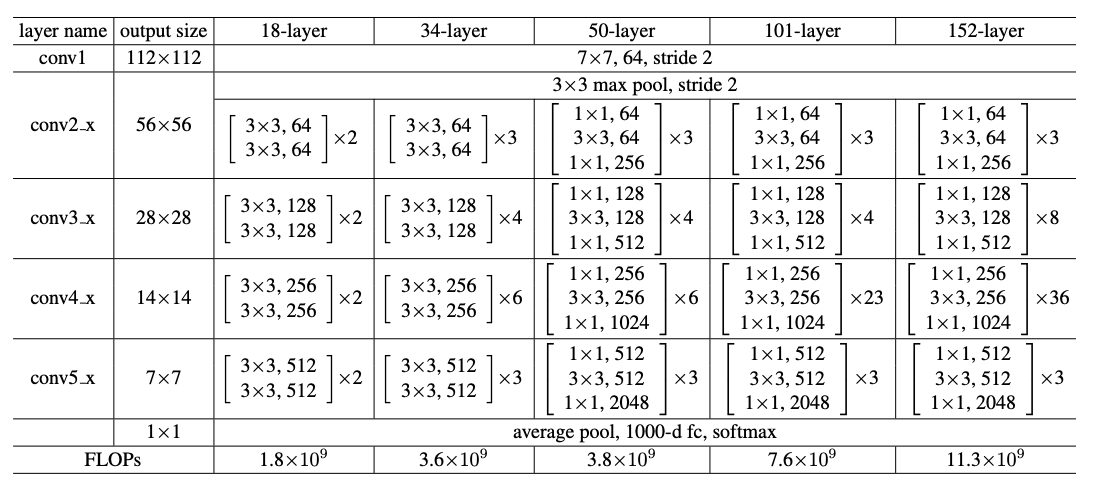
- ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.  
ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다.  
그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.


In [ ]:
# 수정중_12.11-> 12.12 완
def build_resnet_block(input_layer, num_blocks, filters, stride, stage_num, is_bottleneck=False):
    # filters : 블록에서 사용할 필터 수
    # block_num : 스테이지별 블록 번호 식별시 사용
    # is_bottleneck : bottleneck 구조인지 아닌지 확인 -> resnet50의 블록구조는 bottleneck사용 [추후 공부]
    x = input_layer
    shortcut = input_layer # input_layer : 이전 레이어의 출력
    
    for block_num in range(num_blocks):
        block_stride = stride if block_num == 0 else 1
        # 각 스테이지의 첫번째 블록만 stride 적용
        # 다른 블록은 stirde = 1
            
        if is_bottleneck: # 추후 공부 (resnet50)
            # 1x1 conv
            x = Conv2D(filters, (1,1), strides=block_stride, padding='same',name=f'stage{stage_num}_{block_num + 1}_conv1')(x)
            # 다운샘플링 적용
            x = BatchNormalization(name=f'stage{stage_num}_{block_num + 1}_bn1')(x)
            x = ReLU(name=f'stage{stage_num}_{block_num + 1}_relu1')(x)
               
            # 3x3 conv
            x = Conv2D(filters, (3,3), strides=1, padding='same', name=f'stage{stage_num}_{block_num + 1}_conv2')(x)
            # 다운샘플링 적용
            x = BatchNormalization(name=f'stage{stage_num}_{block_num + 1}_bn2')(x)
            x = ReLU(name=f'stage{stage_num}_{block_num + 1}_relu2')(x)

                
            # 1x1 conv
            x = Conv2D(filters * 4, (1,1), strides=1, padding='same', name=f'stage{stage_num}_{block_num + 1}_conv3')(x)
            
            # 차원 4배로 증가 -> 즉 처음 1x1conv,stride=2로 채널 축소(계산량 감소)
            # 이후 3x3 conv로 특성 추출한 뒤 -> 마지막 1x1conv,stirde=1로 다시 채널 확장
            # filters * 4 : 계산 효율을 위해 차원을 줄였던 것을 다시 늘림 -> 고차원의 정보를 다시금 학습하기 위해서.
            x = BatchNormalization(name=f'stage{stage_num}_{block_num + 1}_bn3')(x)
                

            # Shortcut connection for Bottleneck
            if block_num == 0 and (stride > 1 or input_layer.shape[-1] != filters * 4):
                shortcut = Conv2D(filters * 4, (1, 1), strides=block_stride, padding='same', 
                              name=f'stage{stage_num}_{block_num + 1}_shortcut_conv')(input_layer)
                shortcut = BatchNormalization(name=f'stage{stage_num}_{block_num + 1}_shortcut_bn')(shortcut)

        else:
        # basic 블록 (resnet34)
        # weighted layer Conv -> BN -> ReLU : 비선형 관계 가중치 학습
        
         # 3x3 Conv
            x = Conv2D(filters, (3,3), strides=stride, padding='same', name=f'stage{stage_num}_{block_num+1}_conv1')(input_layer)
            # (3,3)필터 크기 고정
            x = BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn1')(x)
            # 첫 번째 블록의 Batch Normalization 레이어 이름은 block1_bn1.
            x = ReLU(name=f'stage{stage_num}_{block_num+1}_relu1')(x)
            
        # 3x3 Conv
            x = Conv2D(filters, (3,3), strides=1, padding='same', name=f'stage{stage_num}_{block_num+1}_conv2')(x)
            x = BatchNormalization(name=f'stage{stage_num}_{block_num+1}_bn2')(x)
        
            # 입,출력 크기 조절 - 크기,채널 동일한 경우 conv2D생략, 입력 텐서를 그대로 사용 / 다를시 1*1 Conv사용, batchnormal로 조정
            if block_num == 0 and (stride > 1 or input_layer.shape[-1] != filters):
                shortcut = Conv2D(filters, (1,1), strides=block_stride, padding='same', name=f'stage{stage_num}_{block_num+1}_shortcut_conv')(input_layer)
                shortcut = BatchNormalization(name=f'stage{stage_num}_{block_num+1}_shortcut_bn')(shortcut)
                # block_num == 0 : 각 스테이지 첫번째 블록인 경우
                # input_layer.shape[-1] != filters : 인풋 레이어의 크기와, 필터 차원이 다른 경우
                # 항상 모든 스테이지 첫번째 블록은, stirde = 2로 크기를 줄이기 때문에, 이를 shortcut(input_layer)도 고려해주는 것
                # 잔차연결을 위해
                
        x = Add(name=f'stage{stage_num}_{block_num+1}_add')([x, shortcut]) # shortcut = input_layer
        x = ReLU(name=f'stage{stage_num}_{block_num+1}_out_relu')(x)
                
        shortcut = x
        
    return x
    
            
#         # 잔차 연결을 위한 전처리
#         stride != 1 or input_layer.shape[-1] != filters:
#             shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', name=f'stage{stage_num}_{block_num+1}_shortcut_conv')(input_layer)
#             shortcut = BatchNormalization(name=f'block{block_num}_shortcut_bn')(shortcut)
        # [추가공부 필요]
        # 1x1 Convolution: 입력 데이터와 출력 데이터의 차원을 맞추기 위해 사용.
        # 조건: 입력과 출력의 크기 또는 채널 수가 다르면 적용.
        

"""
BatchNormalization이 필요한 이유
 1.	Vanishing Gradient 문제 해결:
•	레이어가 깊어질수록 입력 데이터의 분산이 커져 학습이 불안정해질 수 있는데, BN이 이를 완화.
2.	학습 안정화:
•	각 레이어의 출력 분포를 일정하게 유지하여 학습 속도를 증가.
3.	Regularization 효과:
•	배치마다 통계량이 달라지므로 과적합 방지 효과도 있음.
"""

- is_bottleneck : bottleneck 구조인지 아닌지 확인 -> resnet50의 블록구조는 bottleneck사용 [추후 공부 필요]
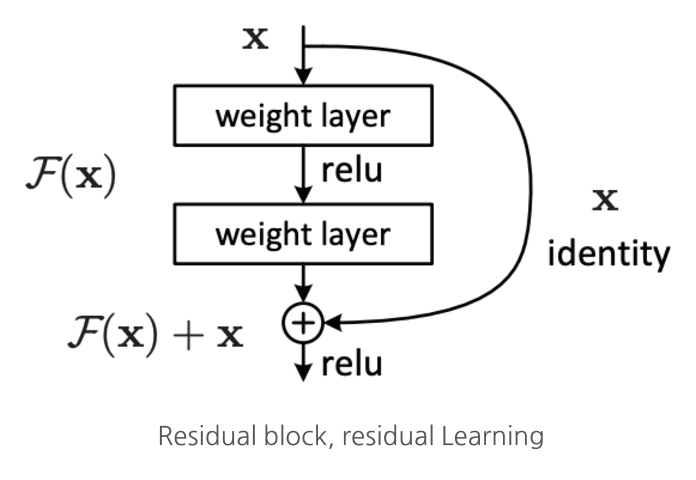
- 공부
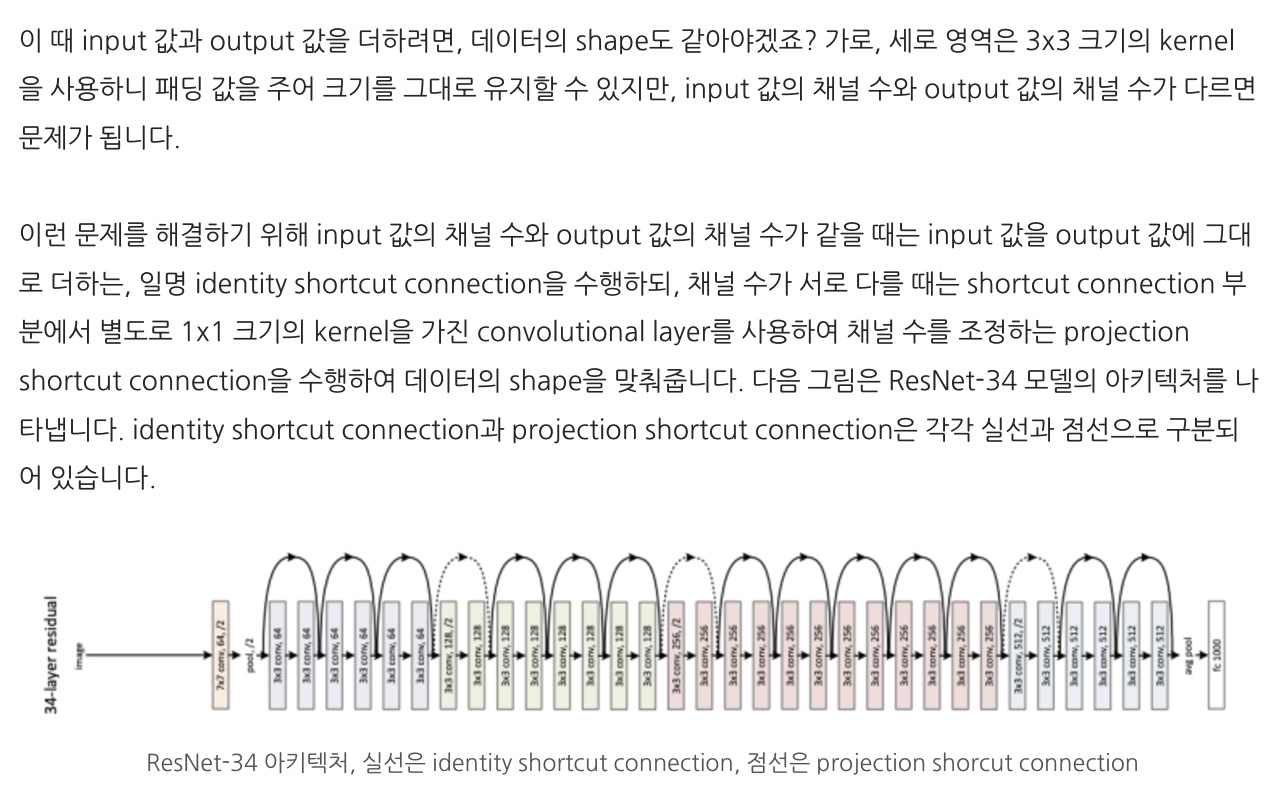
- 추가 공부  
    ResNet 구조에서 다운샘플링이 필요한 이유
	1.	특징 추출의 계층적 처리:
	•	이미지에서 고수준 특징(high-level feature)을 추출하려면, 입력 데이터를 점진적으로 다운샘플링하면서 크기를 줄이고 채널 수를 늘려야 합니다.
	•	다운샘플링은 보통 첫 번째 Conv 레이어와 이후 특정 스테이지의 첫 번째 블록에서 발생합니다.
	2.	Residual Block 연결:
	•	새로운 스테이지에서는 메인 경로와 Shortcut 경로의 출력 크기가 다를 수 있습니다. 이 차이를 해결하기 위해 Shortcut 경로에서도 동일한 다운샘플링이 필요합니다.
  
        
    
- resnet 다운샘플링과, 1x1 입출력 크기 조절 conv 이해  
    ResNet에서 stride != 1이 발생하는 스테이지
	•	ResNet-34와 ResNet-50 모두 동일한 구조에서 발생합니다.
	•	각 스테이지(stage)는 입력 크기를 줄이기 위해 첫 번째 블록의 첫 번째 Conv 레이어에서 stride=2를 사용합니다.

    ㅁ 스테이지별 구조
	1.	Stage 1:  
	•	입력 크기: (H, W, 3) → Conv2D(7x7, stride=2)와 MaxPooling2D(stride=2)로 처리.  
	•	출력 크기: (H/4, W/4, 64)  
	•	특징: 초기 입력 이미지의 크기를 크게 줄이는 단계.  
	2.	Stage 2:  
	•	입력 크기: (H/4, W/4, 64)  
	•	첫 번째 블록의 stride=1 (다운샘플링 없음).  
	•	출력 크기: (H/4, W/4, 64)  
	3.	Stage 3:  
	•	입력 크기: (H/4, W/4, 64)  
	•	첫 번째 블록의 stride=2로 다운샘플링.  
	•	출력 크기: (H/8, W/8, 128)  
	4.	Stage 4:  
	•	입력 크기: (H/8, W/8, 128)  
	•	첫 번째 블록의 stride=2로 다운샘플링.  
	•	출력 크기: (H/16, W/16, 256)  
	5.	Stage 5:  
	•	입력 크기: (H/16, W/16, 256)  
	•	첫 번째 블록의 stride=2로 다운샘플링.  
	•	출력 크기: (H/32, W/32, 512)  
    
    ㅁ 다운샘플링과 stride != 1 조건
	 1.	Stage 전환 시:  
	•	Stage 2 → Stage 3    
	•	Stage 3 → Stage 4  
	•	Stage 4 → Stage 5  
	•	이 시점에서 첫 번째 블록의 stride=2를 적용해 입력 크기를 줄입니다.   
	 2.	Shortcut 경로 처리:  
	•	입력 크기가 줄어들면, Shortcut 경로에서도 동일하게 다운샘플링(stride=2)이 필요합니다.  
	•	또한, 입력 채널 수와 출력 채널 수가 다를 경우 1x1 Convolution으로 채널을 조정합니다.  


  - resnet50, bottleneck 공부  
    Bottleneck 구조란?  
Bottleneck 구조는 ResNet-50, ResNet-101 등에서 사용되는 블록 설계 방식입니다. Bottleneck의 주요 목표는 계산량을 줄이고 효율성을 높이면서 깊은 네트워크를 설계하는 것입니다.  

    Bottleneck 블록의 구조:   
	1.	1x1 Convolution:  
	•	채널 수를 줄여(차원 축소) 계산량을 줄임.  
	•	예:  256 \rightarrow 64 .  
	2.	3x3 Convolution:  
	•	특징을 추출.  
	•	공간적 연산에 초점을 맞춤.  
	3.	1x1 Convolution:  
	•	채널 수를 늘려(차원 확장) 원래 블록 출력 크기와 맞춤.  
	•	예:  64 \rightarrow 256 .  






### 2) ResNet-34, ResNet-50 Complete Model
ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.




In [ ]:
# 변경 필요 12.11 -> 12.12 진행, 완
def build_resnet(input_shape=(32,32,3), is_50 = False, num_classes=10):
    
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # 초기 Conv, Max-Pooling
    x = Conv2D(64, (7,7), strides = 2, padding='same', name='stage1_conv1_conv')(input_layer)
    x = BatchNormalization(name='stage1_conv1_bn')(x)
    x = ReLU(name='stage1_conv1_relu')(x)
    x = MaxPooling2D((3,3), strides=2, padding='same', name='stage1_Maxpool')(x)
    # 초기 64개 필터(출력채널 64), 사이즈(7,7), stirde=2 -> 출력크기는 입력크기의 절반으로 감소
    # stride =2 -> 계산량 감소 및 더작은 특성맵 추출
    # Padding=same -> 출력 크기를 입력크기와 동일하게 맞추기 위한 제로패딩.(입력의 경계부분도 효과적 학습위함)
    
    
    # Resnet config blocks. 구성
    if is_50:
        # resnet50, bottleneck block
        config = [
            (3, 64, True), #Residual num_blocks, filters, is_bottleneck Stage2
            (4, 128, True), # Stage3
            (6, 256, True), # Stage4
            (3, 512, True), # Stage5
        ] 
        
    else:
        # resnet34
        config = [
            (3, 64, False), # 첫번째 stage에서 3개(2개의conv로 구성된)의 residual block, 각블록 필터수는 64개
            (4, 128, False), # 2번째 stage 4개 residual block
            (6, 256, False), 
            (3, 512, False)
        ]
    
    
    # build_resnet_block활용, Complete model 구성
    for stage_num, (num_blocks, filters, is_bottleneck) in enumerate(config, start=2):
    # start = 2 : 인덱스를 2부터 시작, stage_num = 2부터 설정
        stride = 1 if stage_num == 2 else 2 # 2번째 stage만 이미지 크기의 다운샘플링 없게끔 조정
        x = build_resnet_block(x, num_blocks, filters, stride, stage_num, is_bottleneck)
    

    # Global aberage pooling, Output layer 구성
    # 디버깅 1차. 틀린 점
    # x = AveragePooling2D((2,2), name='Avg_Pool')(x)
    if x.shape[1] > 1 and x.shape[2] > 1:
        x = AveragePooling2D((2, 2), strides=(2, 2), name='Avg_Pool')(x)
    else:
        x = AveragePooling2D((1, 1), name='Avg_Pool')(x)
    # (2,2) : 풀링윈도우, 입력텐서를 절반으로 줄임, 2x2 평균값을 계산하여 출력
    # 공간적 크기를 줄이면서, 주요 정보 보존
    
    x = Flatten(name='flatten')(x)
    # 다차원 텐서를 1차원 벡터로 변환 (H/2,W/2,C)->((H/2)*(W/2)*C)크기의 텐서로 변환
    # Fully Connected (Dense) layer에 입력할 수 있는 형태로 변환
    
    output_layer = Dense(num_classes, activation='softmax', name='fc1000')(x)
    # fc layer로 모든 입출력 연결
    # 출력 클래스 수 지정. if 10이면, 10개의 클래스 분류 작업진행, 각 클래스의 확률 나타나는 softmax
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name=f"resnet{'50' if is_50 else '34'}")
    return model

### 2)-1. ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.




In [64]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv1_conv (Conv2D)      (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_conv1_bn (BatchNormaliza (None, 16, 16, 64)   256         stage1_conv1_conv[0][0]          
__________________________________________________________________________________________________
stage1_conv1_relu (ReLU)        (None, 16, 16, 64)   0           stage1_conv1_bn[0][0]            
___________________________________________________________________________________________

	- Resnet 34
    •	Conv1: (7x7 Conv + MaxPool)
	•	Stage1: 3개 Residual Block, 필터 개수: 64
	•	Stage2: 4개 Residual Block, 필터 개수: 128
	•	Stage3: 6개 Residual Block, 필터 개수: 256
	•	Stage4: 3개 Residual Block, 필터 개수: 512
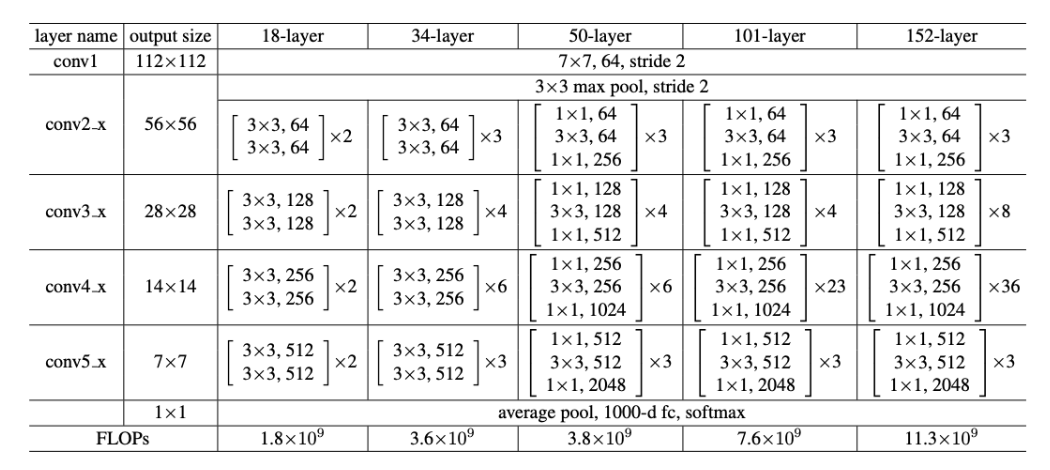
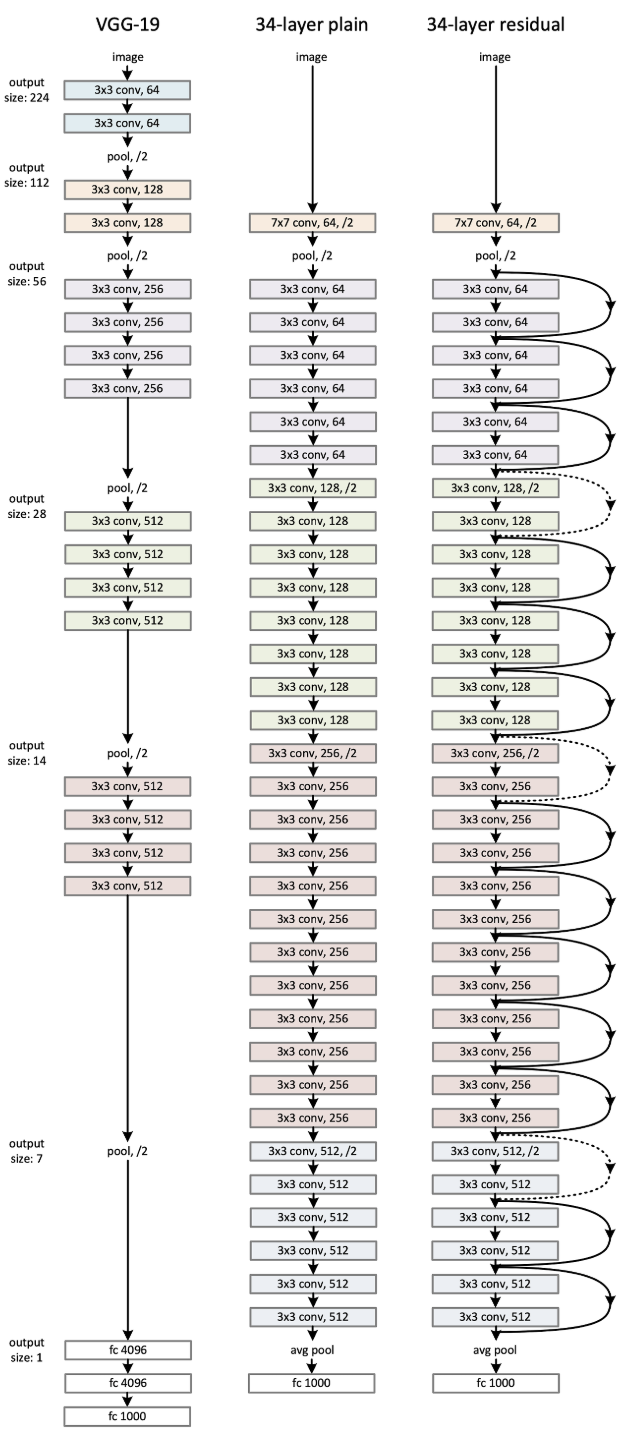

### 2)-2. ResNet-50
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.  
ResNet-50은 구현마다 약간씩 다르게 나올 수 있습니다. 왜냐하면 Residual 블록의 Batch Normalization과 ReLU 레이어의 위치가 논문에 명시되지 않았기 때문이죠!  

하지만 ResNet을 고안한 4인방은 이에 대해 또 한번 논문을 씁니다. Residual 블록에 대해서 자세하게 씁니다. 이 논문을 읽어보면 오리지널 ResNet-50에 대한 힌트가 약.간. 있을 수도 있습니다~!  

Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027







In [65]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv1_conv (Conv2D)      (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_conv1_bn (BatchNormaliza (None, 16, 16, 64)   256         stage1_conv1_conv[0][0]          
__________________________________________________________________________________________________
stage1_conv1_relu (ReLU)        (None, 16, 16, 64)   0           stage1_conv1_bn[0][0]            
___________________________________________________________________________________________

### 3) 일반 네트워크(plain network) 만들기
블록 코드 수정하기  
우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

전체 함수 코드 수정하기  
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

#### - plainnet block 함수

In [66]:
def build_plainnet_block(input_layer, num_blocks, filters, stride, stage_num, is_bottleneck=False):
    x = input_layer 
    
    for block_num in range(num_blocks):
        block_stride = stride if block_num == 0 else 1 
        
        if is_bottleneck:
            # Bottleneck 블록
            x = Conv2D(filters, (1, 1), strides=block_stride, padding='same',
                       name=f'plain_stage{stage_num}_{block_num + 1}_conv1')(x)
            x = BatchNormalization(name=f'plain_stage{stage_num}_{block_num + 1}_bn1')(x)
            x = ReLU(name=f'plain_stage{stage_num}_{block_num + 1}_relu1')(x)

            x = Conv2D(filters, (3, 3), strides=1, padding='same',
                       name=f'plain_stage{stage_num}_{block_num + 1}_conv2')(x)
            x = BatchNormalization(name=f'plain_stage{stage_num}_{block_num + 1}_bn2')(x)
            x = ReLU(name=f'plain_stage{stage_num}_{block_num + 1}_relu2')(x)

            x = Conv2D(filters * 4, (1, 1), strides=1, padding='same',
                       name=f'plain_stage{stage_num}_{block_num + 1}_conv3')(x)
            x = BatchNormalization(name=f'plain_stage{stage_num}_{block_num + 1}_bn3')(x)

        else:
            # Basic 블록
            x = Conv2D(filters, (3, 3), strides=block_stride, padding='same',
                       name=f'plain_stage{stage_num}_{block_num + 1}_conv1')(x)
            x = BatchNormalization(name=f'plain_stage{stage_num}_{block_num + 1}_bn1')(x)
            x = ReLU(name=f'plain_stage{stage_num}_{block_num + 1}_relu1')(x)

            x = Conv2D(filters, (3, 3), strides=1, padding='same',
                       name=f'plain_stage{stage_num}_{block_num + 1}_conv2')(x)
            x = BatchNormalization(name=f'plain_stage{stage_num}_{block_num + 1}_bn2')(x)
            x = ReLU(name=f'plain_stage{stage_num}_{block_num + 1}_relu2')(x)

    return x

#### - plainnet complete model

In [69]:
def build_plainnet(input_shape=(224, 224, 3), is_50=False, num_classes=1000):
    input_layer = Input(shape=input_shape, name='plain_input_layer')

    # 초기 Conv 및 MaxPooling
    x = Conv2D(64, (7, 7), strides=2, padding='same', name='plain_stage1_conv1')(input_layer)
    x = BatchNormalization(name='plain_stage1_bn1')(x)
    x = ReLU(name='plain_stage1_relu1')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same', name='plain_stage1_maxpool')(x)

    # 블록 구성
    if is_50:
        # PlainNet-50
        config = [
            (3, 64, True),  # Stage2
            (4, 128, True),  # Stage3
            (6, 256, True),  # Stage4
            (3, 512, True),  # Stage5
        ]
    else:
        # PlainNet-34
        config = [
            (3, 64, False),  # Stage2
            (4, 128, False),  # Stage3
            (6, 256, False),  # Stage4
            (3, 512, False),  # Stage5
        ]


    for stage_num, (num_blocks, filters, is_bottleneck) in enumerate(config, start=2):
        stride = 1 if stage_num == 2 else 2  # Stage2에서는 stride=1
        x = build_plainnet_block(x, num_blocks, filters, stride, stage_num, is_bottleneck)

    # Average Pooling 및 Fully Connected Layer
    if x.shape[1] > 1 and x.shape[2] > 1:
        x = AveragePooling2D((2, 2), strides=(2, 2), name='plain_avg_pool')(x)
    else:
        x = AveragePooling2D((1, 1), name='plain_avg_pool')(x)

    x = Flatten(name='plain_flatten')(x)
    output_layer = Dense(num_classes, activation='softmax', name='plain_fc')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name=f"PlainNet{'50' if is_50 else '34'}")
    return model

In [70]:
# PlainNet-34
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False)
plainnet_34.summary()

Model: "PlainNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
plain_input_layer (InputLaye [(None, 224, 224, 3)]     0         
_________________________________________________________________
plain_stage1_conv1 (Conv2D)  (None, 112, 112, 64)      9472      
_________________________________________________________________
plain_stage1_bn1 (BatchNorma (None, 112, 112, 64)      256       
_________________________________________________________________
plain_stage1_relu1 (ReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
plain_stage1_maxpool (MaxPoo (None, 56, 56, 64)        0         
_________________________________________________________________
plain_stage2_1_conv1 (Conv2D (None, 56, 56, 64)        36928     
_________________________________________________________________
plain_stage2_1_bn1 (BatchNor (None, 56, 56, 64)        2

In [71]:
# PlainNet-50
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True)
plainnet_50.summary()

Model: "PlainNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
plain_input_layer (InputLaye [(None, 224, 224, 3)]     0         
_________________________________________________________________
plain_stage1_conv1 (Conv2D)  (None, 112, 112, 64)      9472      
_________________________________________________________________
plain_stage1_bn1 (BatchNorma (None, 112, 112, 64)      256       
_________________________________________________________________
plain_stage1_relu1 (ReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
plain_stage1_maxpool (MaxPoo (None, 56, 56, 64)        0         
_________________________________________________________________
plain_stage2_1_conv1 (Conv2D (None, 56, 56, 64)        4160      
_________________________________________________________________
plain_stage2_1_bn1 (BatchNor (None, 56, 56, 64)        2

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
Ablation Study  
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.



In [97]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [98]:
# URL 업데이트
setattr(tfds.image_classification.cats_vs_dogs, '_URL', 
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")


# 데이터셋 로드 및 전처리
def preprocess(image, label, target_size=(224, 224)):
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

def load_data(dataset_name='cats_vs_dogs', batch_size=32, target_size=(224, 224)):
    (train_ds, val_ds), ds_info = tfds.load(
        dataset_name,
        split=['train[:80%]', 'train[80%:]'],
        as_supervised=True,
        with_info=True,
    )
    num_classes = ds_info.features['label'].num_classes
    train_ds = train_ds.map(lambda x, y: preprocess(x, y, target_size)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: preprocess(x, y, target_size)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, num_classes


In [99]:
# ResNet과 PlainNet 빌드
def build_resnet_or_plainnet(input_shape, num_classes, is_resnet=True, is_50=False):
    if is_resnet:
        return build_resnet(input_shape, is_50=is_50, num_classes=num_classes)
    else:
        return build_plainnet(input_shape, is_50=is_50, num_classes=num_classes)

In [100]:
# 학습
def train_model(model, train_ds, val_ds, epochs=10, optimizer='adam', loss='sparse_categorical_crossentropy'):
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history


In [101]:
# 결과 시각화
def plot_history(histories, labels, metric='val_accuracy', ylabel='Accuracy'):
    plt.figure(figsize=(12, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history[metric], label=f'{label} {ylabel}')
    plt.title(f'{ylabel} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


In [102]:
# Ablation Study
def ablation_study(input_shape, train_ds, val_ds, num_classes, epochs=5):
    # ResNet-50, PlainNet-50, ResNet-34, PlainNet-34
    resnet_50 = build_resnet_or_plainnet(input_shape, num_classes, is_resnet=True, is_50=True)
    plainnet_50 = build_resnet_or_plainnet(input_shape, num_classes, is_resnet=False, is_50=True)
    resnet_34 = build_resnet_or_plainnet(input_shape, num_classes, is_resnet=True, is_50=False)
    plainnet_34 = build_resnet_or_plainnet(input_shape, num_classes, is_resnet=False, is_50=False)
    
    # 학습
    resnet_50_history = train_model(resnet_50, train_ds, val_ds, epochs=epochs)
    plainnet_50_history = train_model(plainnet_50, train_ds, val_ds, epochs=epochs)
    resnet_34_history = train_model(resnet_34, train_ds, val_ds, epochs=epochs)
    plainnet_34_history = train_model(plainnet_34, train_ds, val_ds, epochs=epochs)
   
    return resnet_50_history, plainnet_50_history, resnet_34_history, plainnet_34_history

### 5) Ablation Study 및 시각화
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.



In [104]:
# 데이터 로드
dataset_name = 'cats_vs_dogs'
batch_size = 32
input_shape = (224, 224, 3)
train_ds, val_ds, num_classes = load_data(dataset_name, batch_size=batch_size, target_size=(224, 224))

# Ablation Study 실행
resnet_50_history, plainnet_50_history, resnet_34_history, plainnet_34_history = ablation_study(
    input_shape, train_ds, val_ds, num_classes, epochs=15
)

Epoch 1/15
194/582 [=========>....................] - ETA: 2:05 - loss: 1.9642 - accuracy: 0.5350

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:55 - loss: 1.8004 - accuracy: 0.5384

236/582 [===========>..................] - ETA: 1:52 - loss: 1.7605 - accuracy: 0.5379

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:29 - loss: 1.5347 - accuracy: 0.5408

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 1.1853 - accuracy: 0.5748

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 1.1734 - accuracy: 0.5763

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 1.1634 - accuracy: 0.5777

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 1.1423 - accuracy: 0.5780

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 1.1371 - accuracy: 0.5790

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 1.1298 - accuracy: 0.5806

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 210s 353ms/step - loss: 1.1298 - accuracy: 0.5806 - val_loss: 0.7253 - val_accuracy: 0.6141
Epoch 2/15
194/582 [=========>....................] - ETA: 2:09 - loss: 0.6152 - accuracy: 0.6695

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:58 - loss: 0.6129 - accuracy: 0.6694

236/582 [===========>..................] - ETA: 1:54 - loss: 0.6129 - accuracy: 0.6688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.6090 - accuracy: 0.6693

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.5875 - accuracy: 0.6904

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.5868 - accuracy: 0.6912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.5861 - accuracy: 0.6921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.5856 - accuracy: 0.6919

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.5853 - accuracy: 0.6919

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.6923

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 207s 355ms/step - loss: 0.5847 - accuracy: 0.6923 - val_loss: 0.6328 - val_accuracy: 0.6758
Epoch 3/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.5397 - accuracy: 0.7342

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.5441 - accuracy: 0.7312

236/582 [===========>..................] - ETA: 1:54 - loss: 0.5456 - accuracy: 0.7300

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.5476 - accuracy: 0.7253

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.5363 - accuracy: 0.7344

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.5366 - accuracy: 0.7349

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.5363 - accuracy: 0.7348

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.5372 - accuracy: 0.7342

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.5373 - accuracy: 0.7338

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.7343

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 207s 355ms/step - loss: 0.5368 - accuracy: 0.7343 - val_loss: 0.5378 - val_accuracy: 0.7255
Epoch 4/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.5082 - accuracy: 0.7545

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.5065 - accuracy: 0.7546

236/582 [===========>..................] - ETA: 1:54 - loss: 0.5082 - accuracy: 0.7533

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.5049 - accuracy: 0.7528

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.4939 - accuracy: 0.7619

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.4958 - accuracy: 0.7603

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.4953 - accuracy: 0.7605

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.4954 - accuracy: 0.7605

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.4958 - accuracy: 0.7601

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7603

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 213s 366ms/step - loss: 0.4954 - accuracy: 0.7603 - val_loss: 0.5481 - val_accuracy: 0.7188
Epoch 5/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.4720 - accuracy: 0.7774

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.4673 - accuracy: 0.7806

236/582 [===========>..................] - ETA: 1:54 - loss: 0.4675 - accuracy: 0.7805

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.4600 - accuracy: 0.7839

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.4444 - accuracy: 0.7932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.4451 - accuracy: 0.7927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.4446 - accuracy: 0.7928

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.4431 - accuracy: 0.7943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.4431 - accuracy: 0.7943

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.7945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 354ms/step - loss: 0.4431 - accuracy: 0.7945 - val_loss: 0.6573 - val_accuracy: 0.6449
Epoch 6/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.3919 - accuracy: 0.8207

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.3872 - accuracy: 0.8243

236/582 [===========>..................] - ETA: 1:54 - loss: 0.3863 - accuracy: 0.8251

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.3859 - accuracy: 0.8249

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.3798 - accuracy: 0.8285

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.3800 - accuracy: 0.8282

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.3796 - accuracy: 0.8283

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.3781 - accuracy: 0.8293

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.3780 - accuracy: 0.8295

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.8297

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 355ms/step - loss: 0.3775 - accuracy: 0.8297 - val_loss: 0.5914 - val_accuracy: 0.6462
Epoch 7/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.3357 - accuracy: 0.8483

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.3322 - accuracy: 0.8523

236/582 [===========>..................] - ETA: 1:54 - loss: 0.3326 - accuracy: 0.8520

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.3295 - accuracy: 0.8559

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.3188 - accuracy: 0.8609

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.3191 - accuracy: 0.8605

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.3183 - accuracy: 0.8609

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.3168 - accuracy: 0.8619

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.3171 - accuracy: 0.8619

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8616

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 207s 355ms/step - loss: 0.3174 - accuracy: 0.8616 - val_loss: 0.4414 - val_accuracy: 0.7898
Epoch 8/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.2790 - accuracy: 0.8785

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.2781 - accuracy: 0.8785

236/582 [===========>..................] - ETA: 1:54 - loss: 0.2788 - accuracy: 0.8784

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.2811 - accuracy: 0.8772

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.2697 - accuracy: 0.8832

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.2703 - accuracy: 0.8831

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.2694 - accuracy: 0.8836

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.2700 - accuracy: 0.8831

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.2699 - accuracy: 0.8831

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8831

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 354ms/step - loss: 0.2698 - accuracy: 0.8831 - val_loss: 0.5227 - val_accuracy: 0.7264
Epoch 9/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.2368 - accuracy: 0.9027

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.2324 - accuracy: 0.9047

236/582 [===========>..................] - ETA: 1:54 - loss: 0.2303 - accuracy: 0.9064

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.2320 - accuracy: 0.9033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.2298 - accuracy: 0.9043

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.2305 - accuracy: 0.9039

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.2307 - accuracy: 0.9039

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.2302 - accuracy: 0.9039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.2304 - accuracy: 0.9034

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9037

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 207s 355ms/step - loss: 0.2296 - accuracy: 0.9037 - val_loss: 0.3868 - val_accuracy: 0.8345
Epoch 10/15
194/582 [=========>....................] - ETA: 2:07 - loss: 0.2128 - accuracy: 0.9093

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.2059 - accuracy: 0.9127

236/582 [===========>..................] - ETA: 1:53 - loss: 0.2063 - accuracy: 0.9127

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.2086 - accuracy: 0.9120

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.2090 - accuracy: 0.9138

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.2207 - accuracy: 0.9083

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.2290 - accuracy: 0.9028

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.2486 - accuracy: 0.8905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.2525 - accuracy: 0.8876

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8843

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 354ms/step - loss: 0.2577 - accuracy: 0.8843 - val_loss: 0.8470 - val_accuracy: 0.5329
Epoch 11/15
194/582 [=========>....................] - ETA: 2:07 - loss: 0.4454 - accuracy: 0.7887

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.4210 - accuracy: 0.8012

236/582 [===========>..................] - ETA: 1:54 - loss: 0.4165 - accuracy: 0.8038

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.3902 - accuracy: 0.8194

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.3315 - accuracy: 0.8498

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.3307 - accuracy: 0.8503

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.3287 - accuracy: 0.8513

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.3246 - accuracy: 0.8536

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.3241 - accuracy: 0.8535

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8539

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 354ms/step - loss: 0.3233 - accuracy: 0.8539 - val_loss: 0.4973 - val_accuracy: 0.7885
Epoch 12/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.2269 - accuracy: 0.9035

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.2200 - accuracy: 0.9072

236/582 [===========>..................] - ETA: 1:54 - loss: 0.2192 - accuracy: 0.9074

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.2132 - accuracy: 0.9089

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.1991 - accuracy: 0.9165

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.1997 - accuracy: 0.9164

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.2003 - accuracy: 0.9159

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.2011 - accuracy: 0.9156

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.2016 - accuracy: 0.9152

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9155

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 355ms/step - loss: 0.2010 - accuracy: 0.9155 - val_loss: 0.2307 - val_accuracy: 0.8990
Epoch 13/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.1750 - accuracy: 0.9293

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.1696 - accuracy: 0.9317

236/582 [===========>..................] - ETA: 1:54 - loss: 0.1686 - accuracy: 0.9319

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.1661 - accuracy: 0.9317

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.1581 - accuracy: 0.9360

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.1590 - accuracy: 0.9356

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.1591 - accuracy: 0.9352

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.1586 - accuracy: 0.9356

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.1588 - accuracy: 0.9355

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9355

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 355ms/step - loss: 0.1586 - accuracy: 0.9355 - val_loss: 0.3206 - val_accuracy: 0.8697
Epoch 14/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.1431 - accuracy: 0.9410

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.1429 - accuracy: 0.9412

236/582 [===========>..................] - ETA: 1:54 - loss: 0.1411 - accuracy: 0.9421

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.1393 - accuracy: 0.9431

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.1347 - accuracy: 0.9457

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.1348 - accuracy: 0.9458

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.1358 - accuracy: 0.9450

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.1370 - accuracy: 0.9447

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.1371 - accuracy: 0.9446

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9446

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 354ms/step - loss: 0.1368 - accuracy: 0.9446 - val_loss: 0.2696 - val_accuracy: 0.8945
Epoch 15/15
194/582 [=========>....................] - ETA: 2:08 - loss: 0.1299 - accuracy: 0.9454

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.1243 - accuracy: 0.9484

236/582 [===========>..................] - ETA: 1:54 - loss: 0.1252 - accuracy: 0.9481

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.1242 - accuracy: 0.9486

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.1196 - accuracy: 0.9507

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.1210 - accuracy: 0.9503

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.1212 - accuracy: 0.9501

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.1228 - accuracy: 0.9493

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.1230 - accuracy: 0.9492

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9492

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 207s 355ms/step - loss: 0.1229 - accuracy: 0.9492 - val_loss: 0.2923 - val_accuracy: 0.8854
Epoch 1/15
194/582 [=========>....................] - ETA: 1:40 - loss: 1.0285 - accuracy: 0.5150

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.9822 - accuracy: 0.5120

236/582 [===========>..................] - ETA: 1:29 - loss: 0.9701 - accuracy: 0.5123

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.9086 - accuracy: 0.5180

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.8235 - accuracy: 0.5199

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.8207 - accuracy: 0.5202

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.8184 - accuracy: 0.5204

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.8123 - accuracy: 0.5212

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.8111 - accuracy: 0.5213

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8093 - accuracy: 0.5218

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 167s 280ms/step - loss: 0.8093 - accuracy: 0.5218 - val_loss: 0.6844 - val_accuracy: 0.5615
Epoch 2/15
194/582 [=========>....................] - ETA: 1:40 - loss: 0.7409 - accuracy: 0.5026

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.7373 - accuracy: 0.5026

236/582 [===========>..................] - ETA: 1:29 - loss: 0.7357 - accuracy: 0.5026

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:11 - loss: 0.7257 - accuracy: 0.5071

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.7089 - accuracy: 0.5202

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.7082 - accuracy: 0.5204

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.7074 - accuracy: 0.5209

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.7066 - accuracy: 0.5229

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7064 - accuracy: 0.5229

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.5227

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 171s 294ms/step - loss: 0.7062 - accuracy: 0.5227 - val_loss: 0.7117 - val_accuracy: 0.5157
Epoch 3/15
194/582 [=========>....................] - ETA: 1:41 - loss: 0.6840 - accuracy: 0.5324

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.6831 - accuracy: 0.5347

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6827 - accuracy: 0.5372

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6786 - accuracy: 0.5358

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.6789 - accuracy: 0.5415

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6795 - accuracy: 0.5406

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6801 - accuracy: 0.5389

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6809 - accuracy: 0.5366

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6811 - accuracy: 0.5370

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5362

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 279ms/step - loss: 0.6814 - accuracy: 0.5362 - val_loss: 0.7003 - val_accuracy: 0.4961
Epoch 4/15
194/582 [=========>....................] - ETA: 1:40 - loss: 0.7267 - accuracy: 0.5072

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.7233 - accuracy: 0.5041

236/582 [===========>..................] - ETA: 1:29 - loss: 0.7222 - accuracy: 0.5041

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.7159 - accuracy: 0.5051

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.7101 - accuracy: 0.5025

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.7097 - accuracy: 0.5017

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.7094 - accuracy: 0.5014

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.7085 - accuracy: 0.5021

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7084 - accuracy: 0.5020

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7084 - accuracy: 0.5019

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 279ms/step - loss: 0.7084 - accuracy: 0.5019 - val_loss: 0.6946 - val_accuracy: 0.4901
Epoch 5/15
194/582 [=========>....................] - ETA: 1:40 - loss: 0.6961 - accuracy: 0.4977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.6960 - accuracy: 0.4983

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6958 - accuracy: 0.4999

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:11 - loss: 0.6963 - accuracy: 0.5037

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.6956 - accuracy: 0.5051

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6961 - accuracy: 0.5044

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6960 - accuracy: 0.5047

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6964 - accuracy: 0.5029

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6965 - accuracy: 0.5027

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.5030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 279ms/step - loss: 0.6965 - accuracy: 0.5030 - val_loss: 0.6938 - val_accuracy: 0.4914
Epoch 6/15
194/582 [=========>....................] - ETA: 1:40 - loss: 0.6988 - accuracy: 0.5061

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.6978 - accuracy: 0.5058

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6976 - accuracy: 0.5057

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6970 - accuracy: 0.5074

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.6960 - accuracy: 0.5084

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6960 - accuracy: 0.5088

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6961 - accuracy: 0.5092

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6966 - accuracy: 0.5093

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6968 - accuracy: 0.5087

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.5081

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 278ms/step - loss: 0.6969 - accuracy: 0.5081 - val_loss: 0.6934 - val_accuracy: 0.4983
Epoch 7/15
194/582 [=========>....................] - ETA: 1:39 - loss: 1.1320 - accuracy: 0.4997

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 1.0702 - accuracy: 0.5001

236/582 [===========>..................] - ETA: 1:29 - loss: 1.0546 - accuracy: 0.4988

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.9701 - accuracy: 0.5038

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


194/582 [=========>....................] - ETA: 1:40 - loss: 0.6931 - accuracy: 0.5084

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6932 - accuracy: 0.5079

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6932 - accuracy: 0.5082

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6930 - accuracy: 0.5101

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.6931 - accuracy: 0.5096

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6929 - accuracy: 0.5106

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6931 - accuracy: 0.5097

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6932 - accuracy: 0.5107

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6932 - accuracy: 0.5112

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5106

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 278ms/step - loss: 0.6932 - accuracy: 0.5106 - val_loss: 0.6927 - val_accuracy: 0.5043
Epoch 9/15
194/582 [=========>....................] - ETA: 1:39 - loss: 0.6935 - accuracy: 0.5097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6935 - accuracy: 0.5077

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6935 - accuracy: 0.5087

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6928 - accuracy: 0.5125

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 16s - loss: 0.6930 - accuracy: 0.5111

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6930 - accuracy: 0.5114

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6931 - accuracy: 0.5114

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6929 - accuracy: 0.5131

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6929 - accuracy: 0.5135

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5136

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 170s 293ms/step - loss: 0.6929 - accuracy: 0.5136 - val_loss: 0.6923 - val_accuracy: 0.5067
Epoch 10/15
194/582 [=========>....................] - ETA: 1:40 - loss: 0.6953 - accuracy: 0.5169

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.6953 - accuracy: 0.5162

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6955 - accuracy: 0.5148

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6948 - accuracy: 0.5112

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.6935 - accuracy: 0.5161

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6934 - accuracy: 0.5162

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6937 - accuracy: 0.5157

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6934 - accuracy: 0.5174

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6934 - accuracy: 0.5170

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5173

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 161s 277ms/step - loss: 0.6935 - accuracy: 0.5173 - val_loss: 0.6917 - val_accuracy: 0.5067
Epoch 11/15
194/582 [=========>....................] - ETA: 1:39 - loss: 0.6945 - accuracy: 0.5177

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6944 - accuracy: 0.5166

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6945 - accuracy: 0.5156

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6936 - accuracy: 0.5153

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 16s - loss: 0.6928 - accuracy: 0.5174

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6930 - accuracy: 0.5175

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6930 - accuracy: 0.5173

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6930 - accuracy: 0.5168

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6930 - accuracy: 0.5170

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5170

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 277ms/step - loss: 0.6929 - accuracy: 0.5170 - val_loss: 0.6882 - val_accuracy: 0.5170
Epoch 12/15
194/582 [=========>....................] - ETA: 1:39 - loss: 0.6948 - accuracy: 0.5158

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6947 - accuracy: 0.5156

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6945 - accuracy: 0.5162

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6930 - accuracy: 0.5166

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 16s - loss: 0.6912 - accuracy: 0.5212

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6910 - accuracy: 0.5212

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6909 - accuracy: 0.5212

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6912 - accuracy: 0.5210

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6911 - accuracy: 0.5213

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5210

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 161s 277ms/step - loss: 0.6912 - accuracy: 0.5210 - val_loss: 0.6812 - val_accuracy: 0.5114
Epoch 13/15
194/582 [=========>....................] - ETA: 1:39 - loss: 0.6898 - accuracy: 0.5364

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6892 - accuracy: 0.5358

236/582 [===========>..................] - ETA: 1:28 - loss: 0.6887 - accuracy: 0.5361

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6869 - accuracy: 0.5364

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 16s - loss: 0.6839 - accuracy: 0.5417

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6835 - accuracy: 0.5422

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6834 - accuracy: 0.5423

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6845 - accuracy: 0.5406

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6845 - accuracy: 0.5406

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5402

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 161s 277ms/step - loss: 0.6847 - accuracy: 0.5402 - val_loss: 0.6823 - val_accuracy: 0.5112
Epoch 14/15
194/582 [=========>....................] - ETA: 1:40 - loss: 0.6826 - accuracy: 0.5425

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6821 - accuracy: 0.5447

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6816 - accuracy: 0.5437

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6810 - accuracy: 0.5359

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 16s - loss: 0.7011 - accuracy: 0.5227

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.7008 - accuracy: 0.5225

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.7005 - accuracy: 0.5219

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.7115 - accuracy: 0.5225

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7117 - accuracy: 0.5226

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.5227

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 161s 277ms/step - loss: 0.7154 - accuracy: 0.5227 - val_loss: 30.4183 - val_accuracy: 0.5144
Epoch 15/15
194/582 [=========>....................] - ETA: 1:40 - loss: 0.7335 - accuracy: 0.4989

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.7277 - accuracy: 0.5024

236/582 [===========>..................] - ETA: 1:29 - loss: 0.7265 - accuracy: 0.5001

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.7189 - accuracy: 0.5037

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 16s - loss: 0.7093 - accuracy: 0.5051

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.7090 - accuracy: 0.5048

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.7086 - accuracy: 0.5045

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.7078 - accuracy: 0.5053

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7077 - accuracy: 0.5054

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.5055

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 161s 277ms/step - loss: 0.7074 - accuracy: 0.5055 - val_loss: 0.6922 - val_accuracy: 0.5185
Epoch 1/15
195/582 [=========>....................] - ETA: 1:16 - loss: 1.1893 - accuracy: 0.5819

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 1.1340 - accuracy: 0.5920

237/582 [===========>..................] - ETA: 1:08 - loss: 1.1153 - accuracy: 0.5924

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 54s - loss: 1.0233 - accuracy: 0.6049

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.9116 - accuracy: 0.6237

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.9052 - accuracy: 0.6251

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.8996 - accuracy: 0.6264

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.8941 - accuracy: 0.6264

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.8932 - accuracy: 0.6261

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8918 - accuracy: 0.6258

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 127s 213ms/step - loss: 0.8918 - accuracy: 0.6258 - val_loss: 1.0228 - val_accuracy: 0.5445
Epoch 2/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.6593 - accuracy: 0.6603

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:09 - loss: 0.6521 - accuracy: 0.6620

237/582 [===========>..................] - ETA: 1:07 - loss: 0.6510 - accuracy: 0.6621

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.6382 - accuracy: 0.6700

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.6109 - accuracy: 0.6868

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.6094 - accuracy: 0.6880

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.6086 - accuracy: 0.6885

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6074 - accuracy: 0.6887

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6071 - accuracy: 0.6891

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.6891

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 211ms/step - loss: 0.6070 - accuracy: 0.6891 - val_loss: 0.8569 - val_accuracy: 0.6124
Epoch 3/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.5516 - accuracy: 0.7226

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:09 - loss: 0.5479 - accuracy: 0.7232

237/582 [===========>..................] - ETA: 1:07 - loss: 0.5474 - accuracy: 0.7226

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.5426 - accuracy: 0.7259

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.5312 - accuracy: 0.7378

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.5301 - accuracy: 0.7383

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.5301 - accuracy: 0.7382

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.5310 - accuracy: 0.7381

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.5311 - accuracy: 0.7380

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.7380

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 211ms/step - loss: 0.5311 - accuracy: 0.7380 - val_loss: 0.9690 - val_accuracy: 0.5428
Epoch 4/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.4967 - accuracy: 0.7603

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.4969 - accuracy: 0.7607

237/582 [===========>..................] - ETA: 1:08 - loss: 0.4970 - accuracy: 0.7615

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.4951 - accuracy: 0.7642

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.4877 - accuracy: 0.7677

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.4871 - accuracy: 0.7679

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.4868 - accuracy: 0.7684

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.4858 - accuracy: 0.7685

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.4856 - accuracy: 0.7688

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.7682

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.4863 - accuracy: 0.7682 - val_loss: 0.6189 - val_accuracy: 0.6868
Epoch 5/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.4395 - accuracy: 0.7910

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.4373 - accuracy: 0.7921

237/582 [===========>..................] - ETA: 1:08 - loss: 0.4371 - accuracy: 0.7926

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 54s - loss: 0.4353 - accuracy: 0.7951

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.4245 - accuracy: 0.8036

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.4239 - accuracy: 0.8041

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.4227 - accuracy: 0.8046

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.4213 - accuracy: 0.8059

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.4213 - accuracy: 0.8057

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8051

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.4219 - accuracy: 0.8051 - val_loss: 0.4832 - val_accuracy: 0.7588
Epoch 6/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.3622 - accuracy: 0.8409

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.3569 - accuracy: 0.8453

237/582 [===========>..................] - ETA: 1:08 - loss: 0.3575 - accuracy: 0.8445

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.3541 - accuracy: 0.8467

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.3396 - accuracy: 0.8529

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.3392 - accuracy: 0.8528

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.3372 - accuracy: 0.8537

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.3367 - accuracy: 0.8538

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.3368 - accuracy: 0.8535

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3368 - accuracy: 0.8536

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.3368 - accuracy: 0.8536 - val_loss: 0.6221 - val_accuracy: 0.5978
Epoch 7/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.2812 - accuracy: 0.8792

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.2778 - accuracy: 0.8827

237/582 [===========>..................] - ETA: 1:08 - loss: 0.2780 - accuracy: 0.8828

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 54s - loss: 0.2754 - accuracy: 0.8845

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.2635 - accuracy: 0.8898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.2645 - accuracy: 0.8891

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.2632 - accuracy: 0.8900

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.2612 - accuracy: 0.8908

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.2615 - accuracy: 0.8907

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.8906

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.2616 - accuracy: 0.8906 - val_loss: 0.6094 - val_accuracy: 0.6991
Epoch 8/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.2143 - accuracy: 0.9087

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.2103 - accuracy: 0.9107

237/582 [===========>..................] - ETA: 1:08 - loss: 0.2104 - accuracy: 0.9106

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.2083 - accuracy: 0.9117

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.1973 - accuracy: 0.9169

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.1979 - accuracy: 0.9169

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.1974 - accuracy: 0.9170

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1973 - accuracy: 0.9169

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1981 - accuracy: 0.9166

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9165

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 211ms/step - loss: 0.1984 - accuracy: 0.9165 - val_loss: 0.5325 - val_accuracy: 0.7754
Epoch 9/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.1795 - accuracy: 0.9269

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.1714 - accuracy: 0.9303

237/582 [===========>..................] - ETA: 1:08 - loss: 0.1708 - accuracy: 0.9305

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.1702 - accuracy: 0.9295

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.1595 - accuracy: 0.9346

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.1583 - accuracy: 0.9352

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.1582 - accuracy: 0.9352

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1580 - accuracy: 0.9353

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1590 - accuracy: 0.9350

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9349

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 211ms/step - loss: 0.1589 - accuracy: 0.9349 - val_loss: 0.6692 - val_accuracy: 0.6821
Epoch 10/15
195/582 [=========>....................] - ETA: 1:17 - loss: 0.1378 - accuracy: 0.9457

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.1323 - accuracy: 0.9474

237/582 [===========>..................] - ETA: 1:08 - loss: 0.1302 - accuracy: 0.9477

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 54s - loss: 0.1275 - accuracy: 0.9487

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.1218 - accuracy: 0.9519

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.1205 - accuracy: 0.9525

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.1198 - accuracy: 0.9527

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1211 - accuracy: 0.9523

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1211 - accuracy: 0.9521

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9522

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 126s 216ms/step - loss: 0.1209 - accuracy: 0.9522 - val_loss: 0.8582 - val_accuracy: 0.7408
Epoch 11/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.0957 - accuracy: 0.9633

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.0898 - accuracy: 0.9659

237/582 [===========>..................] - ETA: 1:08 - loss: 0.0917 - accuracy: 0.9655

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 54s - loss: 0.0987 - accuracy: 0.9629

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.0929 - accuracy: 0.9653

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.0922 - accuracy: 0.9657

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.0915 - accuracy: 0.9659

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.0907 - accuracy: 0.9663

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.0906 - accuracy: 0.9662

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9659

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.0909 - accuracy: 0.9659 - val_loss: 0.4882 - val_accuracy: 0.8138
Epoch 12/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.0770 - accuracy: 0.9676

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.0732 - accuracy: 0.9693

237/582 [===========>..................] - ETA: 1:08 - loss: 0.0723 - accuracy: 0.9697

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.0741 - accuracy: 0.9697

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.0687 - accuracy: 0.9722

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.0685 - accuracy: 0.9724

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.0679 - accuracy: 0.9727

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.0668 - accuracy: 0.9731

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.0666 - accuracy: 0.9732

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9730

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.0667 - accuracy: 0.9730 - val_loss: 0.7716 - val_accuracy: 0.6999
Epoch 13/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.0539 - accuracy: 0.9806

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.0537 - accuracy: 0.9802

237/582 [===========>..................] - ETA: 1:08 - loss: 0.0527 - accuracy: 0.9807

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 54s - loss: 0.0556 - accuracy: 0.9790

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.0532 - accuracy: 0.9803

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.0538 - accuracy: 0.9802

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.0540 - accuracy: 0.9802

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.0540 - accuracy: 0.9801

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.0540 - accuracy: 0.9802

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9800

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.0541 - accuracy: 0.9800 - val_loss: 0.6149 - val_accuracy: 0.8095
Epoch 14/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.0592 - accuracy: 0.9796

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.0561 - accuracy: 0.9809

237/582 [===========>..................] - ETA: 1:08 - loss: 0.0562 - accuracy: 0.9807

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.0525 - accuracy: 0.9818

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.0439 - accuracy: 0.9846

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.0443 - accuracy: 0.9845

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.0444 - accuracy: 0.9845

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.0455 - accuracy: 0.9843

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.0461 - accuracy: 0.9840

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9841

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 211ms/step - loss: 0.0458 - accuracy: 0.9841 - val_loss: 0.7742 - val_accuracy: 0.7494
Epoch 15/15
195/582 [=========>....................] - ETA: 1:16 - loss: 0.0391 - accuracy: 0.9862

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.0366 - accuracy: 0.9875

237/582 [===========>..................] - ETA: 1:08 - loss: 0.0362 - accuracy: 0.9876

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 54s - loss: 0.0345 - accuracy: 0.9881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.0360 - accuracy: 0.9876

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.0365 - accuracy: 0.9874

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.0367 - accuracy: 0.9872

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.0368 - accuracy: 0.9872

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.0371 - accuracy: 0.9870

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9870

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.0371 - accuracy: 0.9870 - val_loss: 0.5325 - val_accuracy: 0.8257
Epoch 1/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.8071 - accuracy: 0.5027

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7949 - accuracy: 0.4983

237/582 [===========>..................] - ETA: 58s - loss: 0.7912 - accuracy: 0.4976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7698 - accuracy: 0.5073

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7419 - accuracy: 0.5036

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7409 - accuracy: 0.5032

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.7401 - accuracy: 0.5030

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7382 - accuracy: 0.5032

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7377 - accuracy: 0.5032

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.5038

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 184ms/step - loss: 0.7372 - accuracy: 0.5038 - val_loss: 0.6939 - val_accuracy: 0.5103
Epoch 2/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6944 - accuracy: 0.5098

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6944 - accuracy: 0.5118

237/582 [===========>..................] - ETA: 58s - loss: 0.6939 - accuracy: 0.5125

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6932 - accuracy: 0.5210

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6902 - accuracy: 0.5251

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6902 - accuracy: 0.5250

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6902 - accuracy: 0.5254

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6902 - accuracy: 0.5247

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6903 - accuracy: 0.5246

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.6903 - accuracy: 0.5250 - val_loss: 0.6876 - val_accuracy: 0.5421
Epoch 3/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6901 - accuracy: 0.5173

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6896 - accuracy: 0.5193

237/582 [===========>..................] - ETA: 58s - loss: 0.6892 - accuracy: 0.5200

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6877 - accuracy: 0.5295

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6868 - accuracy: 0.5293

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6868 - accuracy: 0.5291

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6868 - accuracy: 0.5291

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6868 - accuracy: 0.5291

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6869 - accuracy: 0.5290

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5294

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6869 - accuracy: 0.5294 - val_loss: 0.6864 - val_accuracy: 0.5529
Epoch 4/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6883 - accuracy: 0.5236

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6879 - accuracy: 0.5259

237/582 [===========>..................] - ETA: 58s - loss: 0.6875 - accuracy: 0.5266

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6861 - accuracy: 0.5337

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6853 - accuracy: 0.5339

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6855 - accuracy: 0.5339

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6856 - accuracy: 0.5339

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6859 - accuracy: 0.5337

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6859 - accuracy: 0.5340

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.5342

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6859 - accuracy: 0.5342 - val_loss: 0.6843 - val_accuracy: 0.5613
Epoch 5/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6898 - accuracy: 0.5333

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6889 - accuracy: 0.5366

237/582 [===========>..................] - ETA: 58s - loss: 0.6885 - accuracy: 0.5369

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6873 - accuracy: 0.5423

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6859 - accuracy: 0.5407

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6860 - accuracy: 0.5407

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6860 - accuracy: 0.5407

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6859 - accuracy: 0.5407

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6861 - accuracy: 0.5405

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5408

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6861 - accuracy: 0.5408 - val_loss: 0.6945 - val_accuracy: 0.5602
Epoch 6/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6867 - accuracy: 0.5463

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6868 - accuracy: 0.5436

237/582 [===========>..................] - ETA: 58s - loss: 0.6866 - accuracy: 0.5458

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6857 - accuracy: 0.5502

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6846 - accuracy: 0.5506

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6846 - accuracy: 0.5501

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6846 - accuracy: 0.5500

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6846 - accuracy: 0.5502

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6847 - accuracy: 0.5499

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5500

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 182ms/step - loss: 0.6848 - accuracy: 0.5500 - val_loss: 0.7455 - val_accuracy: 0.5567
Epoch 7/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6856 - accuracy: 0.5494

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6851 - accuracy: 0.5504

237/582 [===========>..................] - ETA: 58s - loss: 0.6849 - accuracy: 0.5505

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6843 - accuracy: 0.5526

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 10s - loss: 0.6842 - accuracy: 0.5475

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6843 - accuracy: 0.5471

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6844 - accuracy: 0.5470

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6844 - accuracy: 0.5472

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6846 - accuracy: 0.5469

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5469

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 187ms/step - loss: 0.6847 - accuracy: 0.5469 - val_loss: 0.6837 - val_accuracy: 0.5634
Epoch 8/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6870 - accuracy: 0.5446

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6862 - accuracy: 0.5458

237/582 [===========>..................] - ETA: 58s - loss: 0.6858 - accuracy: 0.5463

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6845 - accuracy: 0.5510

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6841 - accuracy: 0.5488

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6842 - accuracy: 0.5482

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6843 - accuracy: 0.5474

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6844 - accuracy: 0.5468

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6845 - accuracy: 0.5463

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.5464

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 182ms/step - loss: 0.6846 - accuracy: 0.5464 - val_loss: 0.6985 - val_accuracy: 0.5544
Epoch 9/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6853 - accuracy: 0.5537

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6847 - accuracy: 0.5552

237/582 [===========>..................] - ETA: 58s - loss: 0.6843 - accuracy: 0.5559

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6834 - accuracy: 0.5579

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6825 - accuracy: 0.5569

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6824 - accuracy: 0.5568

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6825 - accuracy: 0.5566

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6822 - accuracy: 0.5579

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6826 - accuracy: 0.5574

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5574

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 182ms/step - loss: 0.6827 - accuracy: 0.5574 - val_loss: 0.6855 - val_accuracy: 0.5565
Epoch 10/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6887 - accuracy: 0.5505

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6871 - accuracy: 0.5538

237/582 [===========>..................] - ETA: 58s - loss: 0.6863 - accuracy: 0.5549

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6869 - accuracy: 0.5535

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6839 - accuracy: 0.5554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6839 - accuracy: 0.5550

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6838 - accuracy: 0.5552

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6842 - accuracy: 0.5556

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6843 - accuracy: 0.5552

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.5551

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 182ms/step - loss: 0.6843 - accuracy: 0.5551 - val_loss: 0.6984 - val_accuracy: 0.5099
Epoch 11/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6789 - accuracy: 0.5739

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6763 - accuracy: 0.5814

237/582 [===========>..................] - ETA: 58s - loss: 0.6755 - accuracy: 0.5824

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6709 - accuracy: 0.5896

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6638 - accuracy: 0.6020

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6632 - accuracy: 0.6031

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6622 - accuracy: 0.6044

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6617 - accuracy: 0.6050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6619 - accuracy: 0.6049

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.6056

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6616 - accuracy: 0.6056 - val_loss: 0.7198 - val_accuracy: 0.5643
Epoch 12/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6451 - accuracy: 0.6301

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6435 - accuracy: 0.6339

237/582 [===========>..................] - ETA: 58s - loss: 0.6453 - accuracy: 0.6315

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6504 - accuracy: 0.6242

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6464 - accuracy: 0.6268

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6462 - accuracy: 0.6273

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6453 - accuracy: 0.6280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6451 - accuracy: 0.6282

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6454 - accuracy: 0.6280

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.6277

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 187ms/step - loss: 0.6457 - accuracy: 0.6277 - val_loss: 0.6420 - val_accuracy: 0.6322
Epoch 13/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6266 - accuracy: 0.6582

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6239 - accuracy: 0.6608

237/582 [===========>..................] - ETA: 58s - loss: 0.6247 - accuracy: 0.6592

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6212 - accuracy: 0.6598

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6189 - accuracy: 0.6599

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6189 - accuracy: 0.6594

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6177 - accuracy: 0.6602

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6183 - accuracy: 0.6601

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6188 - accuracy: 0.6595

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.6592

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6190 - accuracy: 0.6592 - val_loss: 0.6346 - val_accuracy: 0.6429
Epoch 14/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6017 - accuracy: 0.6732

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6020 - accuracy: 0.6735

237/582 [===========>..................] - ETA: 58s - loss: 0.6039 - accuracy: 0.6708

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6024 - accuracy: 0.6719

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.5970 - accuracy: 0.6793

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.5969 - accuracy: 0.6795

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.5953 - accuracy: 0.6810

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.5951 - accuracy: 0.6817

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.5956 - accuracy: 0.6813

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.6807

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 182ms/step - loss: 0.5961 - accuracy: 0.6807 - val_loss: 1.0439 - val_accuracy: 0.5073
Epoch 15/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.5669 - accuracy: 0.7096

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.5636 - accuracy: 0.7135

237/582 [===========>..................] - ETA: 58s - loss: 0.5652 - accuracy: 0.7111

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.5600 - accuracy: 0.7145

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.5539 - accuracy: 0.7175

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.5540 - accuracy: 0.7180

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.5533 - accuracy: 0.7189

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.5524 - accuracy: 0.7192

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.5524 - accuracy: 0.7195

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.7191

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.5528 - accuracy: 0.7191 - val_loss: 1.8589 - val_accuracy: 0.5088


#### - Resnet34 vs Plainnet34

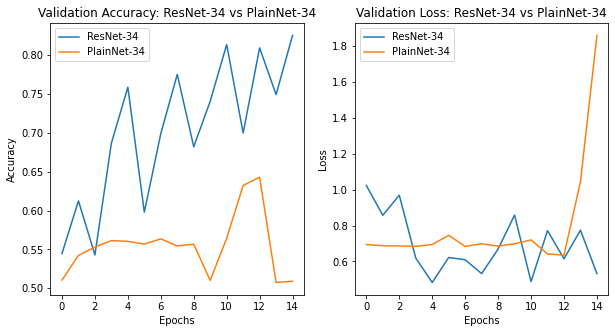

In [107]:
# ResNet-34 vs PlainNet-34
plt.figure(figsize=(10, 5))

# Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
plt.plot(plainnet_34_history.history['val_accuracy'], label='PlainNet-34')
plt.title('Validation Accuracy: ResNet-34 vs PlainNet-34')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
plt.plot(plainnet_34_history.history['val_loss'], label='PlainNet-34')
plt.title('Validation Loss: ResNet-34 vs PlainNet-34')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


- 위 그래프를 보았을때, Resnet의 손실 감소 속도가 PlainNet보다 더 빠름을 볼 수 있습니다. 이는 PlainNet의 네트워크가 깊어질 수록, 손실이 더이상 줄지 않거나, 불안정한 학습을 하고 있기 때문이라고 생각합니다.
- Val accuracy부분도 마찬가지로, Resnet이 좀 더 높은 정확도를 보이는것을 확인할 수 있습니다. 이는 skip connection을 통한 residual learning을 통해 안정적인 학습을 이뤄내기 때문이라 생각합니다.
- 반면 plainNet은 vanishing gradients로 인해 학습이 불안정하여, 검증 정확도가 낮다고 볼 수 있습니다.
- 이러한 문제는 레이어의 수가 깊어질수록 더 확연히 나타날 것이라 생각하기에 아래 Resnet50의 비교를 바로 살펴보겠습니다.

#### - Resnet50 vs Plainnet50

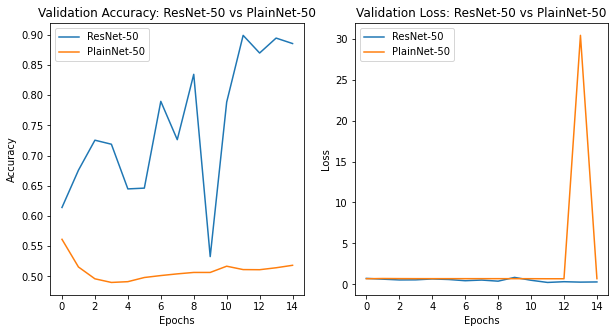

In [108]:
# ResNet-50 vs PlainNet-50
plt.figure(figsize=(10, 5))

# Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
plt.plot(plainnet_50_history.history['val_accuracy'], label='PlainNet-50')
plt.title('Validation Accuracy: ResNet-50 vs PlainNet-50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
plt.plot(plainnet_50_history.history['val_loss'], label='PlainNet-50')
plt.title('Validation Loss: ResNet-50 vs PlainNet-50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 깊은 층으로 갈 수록, Ab study를 통한 Accuracy 성능 차이를 확연히 볼 수 있습니다.
- Resnet은 깊은 네트워크에서도 Residual block을 통해 안정적으로 학습을 진행하는 반면 PlainNet은 skip connection이 존재하지 않아 베니싱 그라디언트 문제를 해결 할 수 없고, 따라서 불안정한 학습으로 낮은 Accuracy를 보임을 확인할 수 있습니다.

- 특이한저은, 깊은 레이어를 기반으로, val_loss가 10에폭까지는 두 모델의 큰 차이가 보이지 않은 점입니다.
- 이에 대한 추론은, 하단 Loss=0 근처를 더 확대 한 뒤 분석해보겠습니다.

#### - val Loss 추가 분석

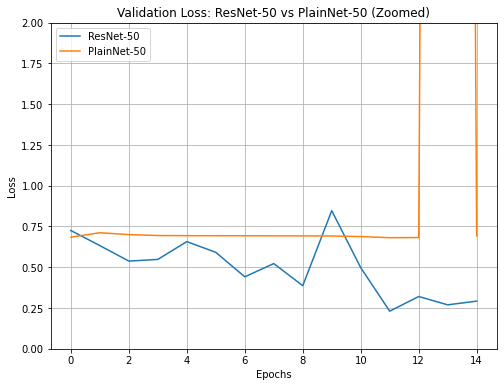

In [137]:
# Validation Loss 분석 위해, 0근처 확대 시각화
plt.figure(figsize=(8, 6))

plt.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
plt.plot(plainnet_50_history.history['val_loss'], label='PlainNet-50')
plt.title('Validation Loss: ResNet-50 vs PlainNet-50 (Zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Y축 범위를 지정 (0부터 2 사이로 확대)
plt.ylim(0, 2)

plt.legend()
plt.grid()
plt.show()

- Loss = 0 근처에서 각 모델의 Loss변화를 살펴보니 ResNet50이 안정적으로 학습하며 Loss를 꾸준히 줄여나가고 있음을 볼 수 있습니다.
- 반면에 Plainnet50은 Loss의 감소가 보이지 않고, 12에폭 부터 Loss값이 튀는 현상이 보입니다.
- 이를 바탕으로 잔차연결은, 학습 성능을 높이는데 기여를 한다는 점을 입증할 수 있습니다.

#### - Resnet34 vs Resnet50 & 전체 비교

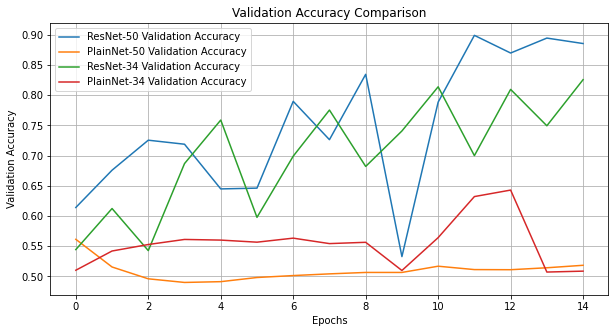

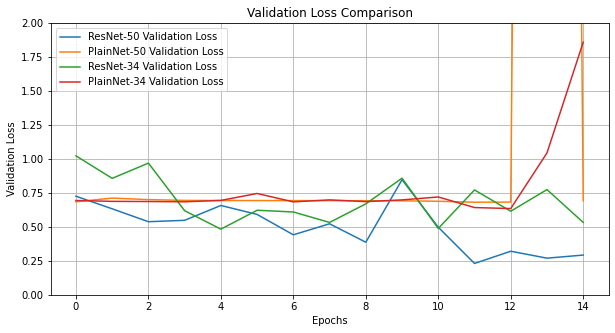

In [138]:
# Validation Accuracy 비교
plt.figure(figsize=(10, 5))
plt.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50 Validation Accuracy')
plt.plot(plainnet_50_history.history['val_accuracy'], label='PlainNet-50 Validation Accuracy')
plt.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34 Validation Accuracy')
plt.plot(plainnet_34_history.history['val_accuracy'], label='PlainNet-34 Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Validation Loss 비교
plt.figure(figsize=(10, 5))
plt.plot(resnet_50_history.history['val_loss'], label='ResNet-50 Validation Loss')
plt.plot(plainnet_50_history.history['val_loss'], label='PlainNet-50 Validation Loss')
plt.plot(resnet_34_history.history['val_loss'], label='ResNet-34 Validation Loss')
plt.plot(plainnet_34_history.history['val_loss'], label='PlainNet-34 Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

plt.ylim(0, 2)

plt.legend()
plt.grid()
plt.show()

- 확연하게 Resnet 모델의 Accuracy가 높음을 확인할 수 있습니다.
- Resnet34보다 Resnet50이 더 높은 accuracy를 보임을 확인할 수 있습니다. 깊은 레이어를 가질 수록 데이터에 대한 학습 성능이 더 좋음을 확인하였습니다.
--- 
- Loss는 상대적으로 Resnet 모델이 손실을 줄여나가고 있음을 볼 수 있습니다.

#### - [Ab study #1차 실험 - 실패]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Epoch 1/5
194/582 [=========>....................] - ETA: 1:58 - loss: 1.6500 - accuracy: 0.5333

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:48 - loss: 1.5159 - accuracy: 0.5381

237/582 [===========>..................] - ETA: 1:45 - loss: 1.4813 - accuracy: 0.5418

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 1:23 - loss: 1.2887 - accuracy: 0.5557

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 20s - loss: 1.0080 - accuracy: 0.6077

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 16s - loss: 0.9976 - accuracy: 0.6104

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.9894 - accuracy: 0.6124

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.9710 - accuracy: 0.6156

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.9670 - accuracy: 0.6167

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.9614 - accuracy: 0.6178

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 267s 346ms/step - loss: 0.9614 - accuracy: 0.6178 - val_loss: 0.5939 - val_accuracy: 0.6769
Epoch 2/5
194/582 [=========>....................] - ETA: 2:08 - loss: 0.5669 - accuracy: 0.7025

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.5651 - accuracy: 0.7028

236/582 [===========>..................] - ETA: 1:54 - loss: 0.5637 - accuracy: 0.7046

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.5632 - accuracy: 0.7046

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.5486 - accuracy: 0.7187

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.5483 - accuracy: 0.7189

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.5475 - accuracy: 0.7197

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.5468 - accuracy: 0.7201

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.5466 - accuracy: 0.7202

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.7210

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 354ms/step - loss: 0.5462 - accuracy: 0.7210 - val_loss: 0.6335 - val_accuracy: 0.6629
Epoch 3/5
194/582 [=========>....................] - ETA: 2:08 - loss: 0.5801 - accuracy: 0.7099

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.5776 - accuracy: 0.7084

236/582 [===========>..................] - ETA: 1:54 - loss: 0.5755 - accuracy: 0.7088

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.5657 - accuracy: 0.7153

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.5398 - accuracy: 0.7316

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.5393 - accuracy: 0.7320

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.5377 - accuracy: 0.7331

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.5359 - accuracy: 0.7335

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.5358 - accuracy: 0.7336

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.7341

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 354ms/step - loss: 0.5354 - accuracy: 0.7341 - val_loss: 0.8025 - val_accuracy: 0.6210
Epoch 4/5
194/582 [=========>....................] - ETA: 2:07 - loss: 0.4703 - accuracy: 0.7779

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.4705 - accuracy: 0.7775

236/582 [===========>..................] - ETA: 1:53 - loss: 0.4707 - accuracy: 0.7770

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.4649 - accuracy: 0.7799

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.4514 - accuracy: 0.7897

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.4514 - accuracy: 0.7898

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.4504 - accuracy: 0.7903

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.4488 - accuracy: 0.7911

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.4491 - accuracy: 0.7910

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.7901

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 353ms/step - loss: 0.4503 - accuracy: 0.7901 - val_loss: 0.6681 - val_accuracy: 0.6410
Epoch 5/5
194/582 [=========>....................] - ETA: 2:07 - loss: 0.4016 - accuracy: 0.8196

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:57 - loss: 0.4015 - accuracy: 0.8200

236/582 [===========>..................] - ETA: 1:53 - loss: 0.4016 - accuracy: 0.8193

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:30 - loss: 0.3970 - accuracy: 0.8201

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 21s - loss: 0.3803 - accuracy: 0.8308

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 17s - loss: 0.3813 - accuracy: 0.8307

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.3807 - accuracy: 0.8310

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.3796 - accuracy: 0.8317

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.3795 - accuracy: 0.8318

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8319

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 206s 354ms/step - loss: 0.3796 - accuracy: 0.8319 - val_loss: 0.4747 - val_accuracy: 0.7693
Epoch 1/5
194/582 [=========>....................] - ETA: 1:40 - loss: 1.1770 - accuracy: 0.5040

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 1.1245 - accuracy: 0.5026

236/582 [===========>..................] - ETA: 1:29 - loss: 1.1067 - accuracy: 0.5021

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 1.0152 - accuracy: 0.4996

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.8893 - accuracy: 0.5128

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.8855 - accuracy: 0.5127

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.8818 - accuracy: 0.5137

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.8736 - accuracy: 0.5153

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.8717 - accuracy: 0.5152

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8691 - accuracy: 0.5156

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 166s 280ms/step - loss: 0.8691 - accuracy: 0.5156 - val_loss: 0.7253 - val_accuracy: 0.5527
Epoch 2/5
194/582 [=========>....................] - ETA: 1:40 - loss: 0.6727 - accuracy: 0.5957

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6725 - accuracy: 0.5975

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6725 - accuracy: 0.5971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6703 - accuracy: 0.6001

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.6714 - accuracy: 0.5956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6716 - accuracy: 0.5963

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6717 - accuracy: 0.5959

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6720 - accuracy: 0.5953

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6720 - accuracy: 0.5951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.5944

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 171s 293ms/step - loss: 0.6722 - accuracy: 0.5944 - val_loss: 0.7003 - val_accuracy: 0.5243
Epoch 3/5
194/582 [=========>....................] - ETA: 1:40 - loss: 0.7406 - accuracy: 0.5243

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:32 - loss: 0.7338 - accuracy: 0.5289

236/582 [===========>..................] - ETA: 1:29 - loss: 0.7320 - accuracy: 0.5290

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.7222 - accuracy: 0.5307

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.7081 - accuracy: 0.5432

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.7078 - accuracy: 0.5434

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.7073 - accuracy: 0.5443

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.7060 - accuracy: 0.5466

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7058 - accuracy: 0.5469

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.5467

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 278ms/step - loss: 0.7055 - accuracy: 0.5467 - val_loss: 0.6834 - val_accuracy: 0.5608
Epoch 4/5
194/582 [=========>....................] - ETA: 1:40 - loss: 0.6774 - accuracy: 0.5909

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6786 - accuracy: 0.5852

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6780 - accuracy: 0.5857

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6761 - accuracy: 0.5870

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.6848 - accuracy: 0.5641

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6849 - accuracy: 0.5635

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6853 - accuracy: 0.5629

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6860 - accuracy: 0.5606

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6861 - accuracy: 0.5600

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5578

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 278ms/step - loss: 0.6866 - accuracy: 0.5578 - val_loss: 0.6966 - val_accuracy: 0.5114
Epoch 5/5
194/582 [=========>....................] - ETA: 1:40 - loss: 0.6977 - accuracy: 0.5137

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:31 - loss: 0.6967 - accuracy: 0.5156

236/582 [===========>..................] - ETA: 1:29 - loss: 0.6966 - accuracy: 0.5154

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:10 - loss: 0.6958 - accuracy: 0.5213

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 17s - loss: 0.6926 - accuracy: 0.5314

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 13s - loss: 0.6923 - accuracy: 0.5326

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 10s - loss: 0.6921 - accuracy: 0.5328

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 3s - loss: 0.6919 - accuracy: 0.5349

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6918 - accuracy: 0.5353

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5351

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 162s 278ms/step - loss: 0.6919 - accuracy: 0.5351 - val_loss: 0.6877 - val_accuracy: 0.5497
Epoch 1/5
195/582 [=========>....................] - ETA: 1:16 - loss: 1.2920 - accuracy: 0.5532

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:09 - loss: 1.2423 - accuracy: 0.5545

237/582 [===========>..................] - ETA: 1:07 - loss: 1.2308 - accuracy: 0.5538

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 1.1108 - accuracy: 0.5597

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.9300 - accuracy: 0.5887

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.9219 - accuracy: 0.5914

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.9151 - accuracy: 0.5929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.9010 - accuracy: 0.5961

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.8983 - accuracy: 0.5967

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.8948 - accuracy: 0.5973

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 127s 212ms/step - loss: 0.8948 - accuracy: 0.5973 - val_loss: 0.8291 - val_accuracy: 0.6129
Epoch 2/5
195/582 [=========>....................] - ETA: 1:16 - loss: 0.5887 - accuracy: 0.6913

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.5864 - accuracy: 0.6929

237/582 [===========>..................] - ETA: 1:08 - loss: 0.5867 - accuracy: 0.6915

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.5828 - accuracy: 0.6954

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.5672 - accuracy: 0.7085

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.5670 - accuracy: 0.7090

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.5658 - accuracy: 0.7101

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.5652 - accuracy: 0.7106

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.5651 - accuracy: 0.7106

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7111

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 211ms/step - loss: 0.5646 - accuracy: 0.7111 - val_loss: 0.8681 - val_accuracy: 0.6109
Epoch 3/5
195/582 [=========>....................] - ETA: 1:16 - loss: 0.5353 - accuracy: 0.7351

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.5328 - accuracy: 0.7365

237/582 [===========>..................] - ETA: 1:08 - loss: 0.5328 - accuracy: 0.7360

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 54s - loss: 0.5286 - accuracy: 0.7372

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.5144 - accuracy: 0.7486

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.5144 - accuracy: 0.7486

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.5133 - accuracy: 0.7497

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.5122 - accuracy: 0.7507

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.5122 - accuracy: 0.7505

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5121 - accuracy: 0.7502

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.5121 - accuracy: 0.7502 - val_loss: 0.5724 - val_accuracy: 0.6980
Epoch 4/5
195/582 [=========>....................] - ETA: 1:16 - loss: 0.4697 - accuracy: 0.7790

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.4666 - accuracy: 0.7803

237/582 [===========>..................] - ETA: 1:08 - loss: 0.4659 - accuracy: 0.7798

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.4594 - accuracy: 0.7835

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.4486 - accuracy: 0.7898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.4492 - accuracy: 0.7893

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.4481 - accuracy: 0.7900

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.4463 - accuracy: 0.7912

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.4464 - accuracy: 0.7913

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.7913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 211ms/step - loss: 0.4461 - accuracy: 0.7913 - val_loss: 0.6022 - val_accuracy: 0.6975
Epoch 5/5
195/582 [=========>....................] - ETA: 1:16 - loss: 0.4095 - accuracy: 0.8157

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:10 - loss: 0.4079 - accuracy: 0.8164

237/582 [===========>..................] - ETA: 1:08 - loss: 0.4069 - accuracy: 0.8162

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 53s - loss: 0.4006 - accuracy: 0.8172

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 12s - loss: 0.3905 - accuracy: 0.8229

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 10s - loss: 0.3914 - accuracy: 0.8221

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 8s - loss: 0.3906 - accuracy: 0.8226

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.3890 - accuracy: 0.8237

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.3894 - accuracy: 0.8237

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8241

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 123s 212ms/step - loss: 0.3892 - accuracy: 0.8241 - val_loss: 0.6622 - val_accuracy: 0.6872
Epoch 1/5
195/582 [=========>....................] - ETA: 1:06 - loss: 0.7948 - accuracy: 0.5146

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7833 - accuracy: 0.5153

237/582 [===========>..................] - ETA: 58s - loss: 0.7798 - accuracy: 0.5125

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7611 - accuracy: 0.5138

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7349 - accuracy: 0.5148

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7340 - accuracy: 0.5137

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.7333 - accuracy: 0.5133

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7317 - accuracy: 0.5130

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7314 - accuracy: 0.5127

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7308 - accuracy: 0.5132

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 110s 184ms/step - loss: 0.7308 - accuracy: 0.5132 - val_loss: 0.6950 - val_accuracy: 0.5099
Epoch 2/5
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6987 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6973 - accuracy: 0.5030

237/582 [===========>..................] - ETA: 58s - loss: 0.6975 - accuracy: 0.5049

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6941 - accuracy: 0.5088

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6868 - accuracy: 0.5307

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6870 - accuracy: 0.5317

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6866 - accuracy: 0.5326

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6862 - accuracy: 0.5349

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6861 - accuracy: 0.5351

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.5352

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.6859 - accuracy: 0.5352 - val_loss: 1.6589 - val_accuracy: 0.5314
Epoch 3/5
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6716 - accuracy: 0.5752

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6710 - accuracy: 0.5743

237/582 [===========>..................] - ETA: 58s - loss: 0.6713 - accuracy: 0.5737

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6722 - accuracy: 0.5674

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6695 - accuracy: 0.5740

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6696 - accuracy: 0.5747

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6694 - accuracy: 0.5748

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6691 - accuracy: 0.5759

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6691 - accuracy: 0.5759

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.5758

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.6690 - accuracy: 0.5758 - val_loss: 2.2818 - val_accuracy: 0.5252
Epoch 4/5
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6674 - accuracy: 0.5829

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6666 - accuracy: 0.5833

237/582 [===========>..................] - ETA: 58s - loss: 0.6666 - accuracy: 0.5832

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6657 - accuracy: 0.5811

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6606 - accuracy: 0.5885

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6607 - accuracy: 0.5892

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6601 - accuracy: 0.5897

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6601 - accuracy: 0.5909

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6602 - accuracy: 0.5908

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.5912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.6598 - accuracy: 0.5912 - val_loss: 0.6649 - val_accuracy: 0.5785
Epoch 5/5
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6505 - accuracy: 0.6038

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6490 - accuracy: 0.6048

237/582 [===========>..................] - ETA: 58s - loss: 0.6487 - accuracy: 0.6054

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6487 - accuracy: 0.6059

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6509 - accuracy: 0.6023

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6504 - accuracy: 0.6034

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6497 - accuracy: 0.6037

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6504 - accuracy: 0.6029

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6504 - accuracy: 0.6029

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6035

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6502 - accuracy: 0.6035 - val_loss: 0.7419 - val_accuracy: 0.5669


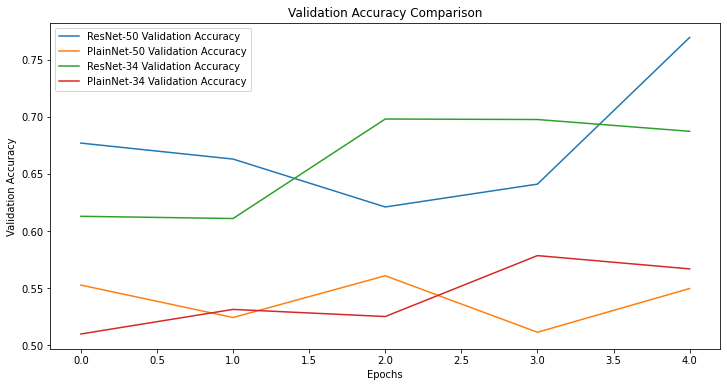

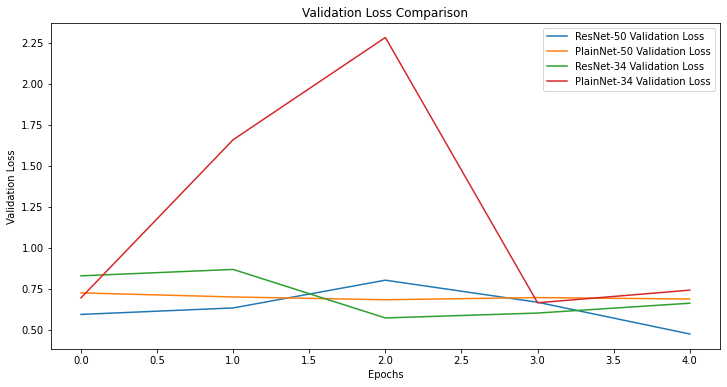

In [86]:
# 1차 실험 - 실패

# # 데이터 로드
# dataset_name = 'cats_vs_dogs'
# batch_size = 32
# input_shape = (224, 224, 3)
# train_ds, val_ds, num_classes = load_data(dataset_name, batch_size=batch_size, target_size=(224, 224))

# # Ablation Study 실행
# ablation_study(input_shape, train_ds, val_ds, num_classes, epochs=5)


- 시간이 오래 걸릴 것 같아, 에폭을 5로 설정하였는데, 그래프를 볼 때 ABstudy를 할 수 없어, 재실험을 진행하였습니다.

#### - Ablation Study 결과분석 표

In [135]:
import pandas as pd
# Validation Accuracy와 Loss 값 추출
resnet_34_val_acc = resnet_34_history.history['val_accuracy'][-1] * 100  # 마지막 에포크 값, 퍼센트로 변환
plainnet_34_val_acc = plainnet_34_history.history['val_accuracy'][-1] * 100
resnet_50_val_acc = resnet_50_history.history['val_accuracy'][-1] * 100
plainnet_50_val_acc = plainnet_50_history.history['val_accuracy'][-1] * 100

resnet_34_val_loss = resnet_34_history.history['val_loss'][-1]
plainnet_34_val_loss = plainnet_34_history.history['val_loss'][-1]
resnet_50_val_loss = resnet_50_history.history['val_loss'][-1]
plainnet_50_val_loss = plainnet_50_history.history['val_loss'][-1]

# Ablation Study 결과 데이터 생성
data = {
    "모델": ["ResNet-34", "PlainNet-34", "ResNet-50", "PlainNet-50"],
    "Validation Accuracy (%)": [
        resnet_34_val_acc, plainnet_34_val_acc, resnet_50_val_acc, plainnet_50_val_acc
    ],
    "Validation Loss": [
        resnet_34_val_loss, plainnet_34_val_loss, resnet_50_val_loss, plainnet_50_val_loss
    ]
}

# DataFrame 생성
ablation_df = pd.DataFrame(data)

# 결과 출력
ablation_df

,모델,Validation Accuracy (%),Validation Loss
0,ResNet-34,82.566637,0.532517
1,PlainNet-34,50.881344,1.858866
2,ResNet-50,88.542563,0.292308
3,PlainNet-50,51.848668,0.692181


### 6) 추가실험

### Vanishing gradient 확인하기

[실험 구상]
- 네트워크의 각 층별 그레이던트의 크기를 구하기 
- 깊은 네트워크에서 그레디언트가 점차 0에 가까워지는 것을 볼 것
- plainNet과 Resnet의 그레디언트를 비교, Resnet은 잔차연결로 위 문제를 해결하였음을 볼 것

In [110]:
import numpy as np

In [125]:
# gradient 추적 함수
def value_gradients(model, dataset, num_batches=10):
    gradients_per_layer = {layer.name: [] for layer in model.layers if 'conv' in layer.name or 'dense' in layer.name}
    # 그레디언트 저장 공간 : Conv2D, Dense 레이어 이름을 키로, 그레디언트 크기 리스트 값 저장
    for step, (x_batch, y_batch) in enumerate(dataset.take(num_batches)):
    # x_batch, y_batch : 입력데이터, 레이블
    # step : 현재 처리중인 배치의 인덱스 (1번배치 step:0, 2번배치 step:1)
        with tf.GradientTape() as tape: # (텐서의 연산을 기록, 연산에 대한 그레디언트 계산) -> Loss계산, 모델 가중치에 대해 미분 = 그레디언트
            predictions = model(x_batch, training=True) # 모델 예측값
            # 모델의 출력 = 클래스별 확률(softmax) : (batch_size, num_classes)
            # training=True : 모델이 훈련시 작동하도록
            loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_batch, predictions) # 손실 계산
            # 다중 클래스 분류 sparsecategorical
        gradients = tape.gradient(loss, model.trainable_weights)
        # 학습가능한 가중치에 대해 손실 함수의 그레디언트 계산
                           
                           
        for layer, grad in zip(model.layers, gradients):
        # model.layers : 모델의 다양한 레이어 리스트를 반환, zip으로 레이어와, 해당 그레이던으를 묶어줌
        # Conv2D나 Dense 레이어만 선택 -> 학습 가중치를 포함하기 때문
            if 'conv' in layer.name or 'dense' in layer.name:
                if grad is not None:
                    gradients_per_layer[layer.name].append(np.mean(np.abs(grad.numpy())))
                    # grad : 현재 레이어의 가중치에 대한 그레디언트.
                    # 평균값을 통해, 레이어 전체 그레디언트 크기를 표현
                    # 각 레이어 이름을 키로, 평균 그레디언트 크기를 리스트 값으로
                    # 중요한 점 : 배치마다 계산된 그레디언트 크기를 저장하는 것 -> 최종 평균 낼 필요가 있음
                           
                           
    avg_gradients = {layer: np.mean(values) for layer, values in gradients_per_layer.items() if values}
    # 딕셔너리 컴프리헨션 구조 사용 {key: value_expression for key, value in source_dict.items() if condition}
    # key value: 새로 생성될 딕셔너리의 키, 값 / soure_dict : 원본 딕셔너리 키,값 쌍 반복 / if condition : 조건을 만족하는 키,값 만 처리
    return avg_gradients

In [126]:
dataset_name = 'cats_vs_dogs'
batch_size = 32
input_shape = (224, 224, 3)
train_ds, val_ds, num_classes = load_data(dataset_name, batch_size=batch_size, target_size=(224, 224))

# ResNet-50
resnet_50 = build_resnet_or_plainnet(input_shape, num_classes, is_resnet=True, is_50=True)
# PlainNet-50
plainnet_50 = build_resnet_or_plainnet(input_shape, num_classes, is_resnet=False, is_50=True)

In [127]:
# ResNet-50 모델에서 그래디언트 추적
resnet50_gradients = value_gradients(resnet_50, train_ds)

# PlainNet-50 모델에서 그래디언트 추적
plainnet50_gradients = value_gradients(plainnet_50, train_ds)

In [131]:
# 시각화
# 그래디언트 크기를 레이어별로 비교
resnet_layers = list(resnet50_gradients.keys())
plainnet_layers = list(plainnet50_gradients.keys())

resnet_grad_values = list(resnet50_gradients.values())
plainnet_grad_values = list(plainnet50_gradients.values())


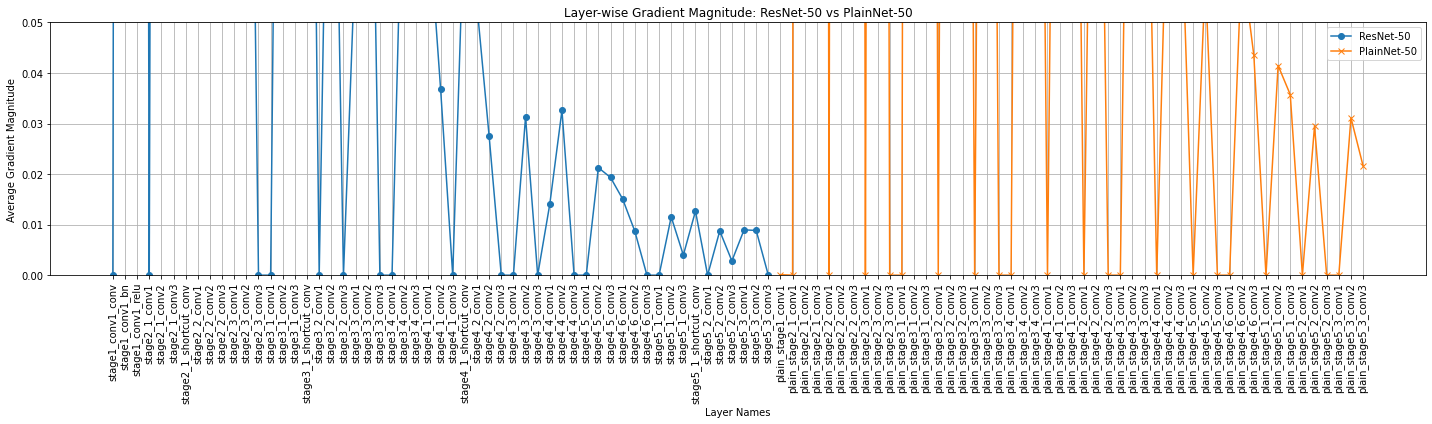

In [143]:
# 그래프 그리기
plt.figure(figsize=(20, 6))
plt.plot(resnet_layers, resnet_grad_values, label='ResNet-50', marker='o')
plt.plot(plainnet_layers, plainnet_grad_values, label='PlainNet-50', marker='x')
plt.xticks(rotation=90)  # x축 레이블 기울이기
plt.xlabel('Layer Names')
plt.ylabel('Average Gradient Magnitude')
plt.title('Layer-wise Gradient Magnitude: ResNet-50 vs PlainNet-50')
plt.legend()
plt.ylim(0, 0.05)

plt.grid()
plt.tight_layout()
plt.show()

- 좌측 파랑색이 Resnet50의 Gradient 크기(배치평균)이며 우측은 PlainNet50의 Gradient 크기(배치평균)입니다.
- Gradient가 0이 된 횟수를 비교해보면 resnet50은 18번 / plainnet50은 22번 입니다.
- 고민해볼 점 : Resnet50이 상대적으로 빠르게 내려가는데 이유를 분석해 볼 필요가 있다. (시간상 좀있다!)

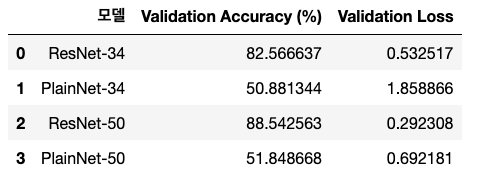


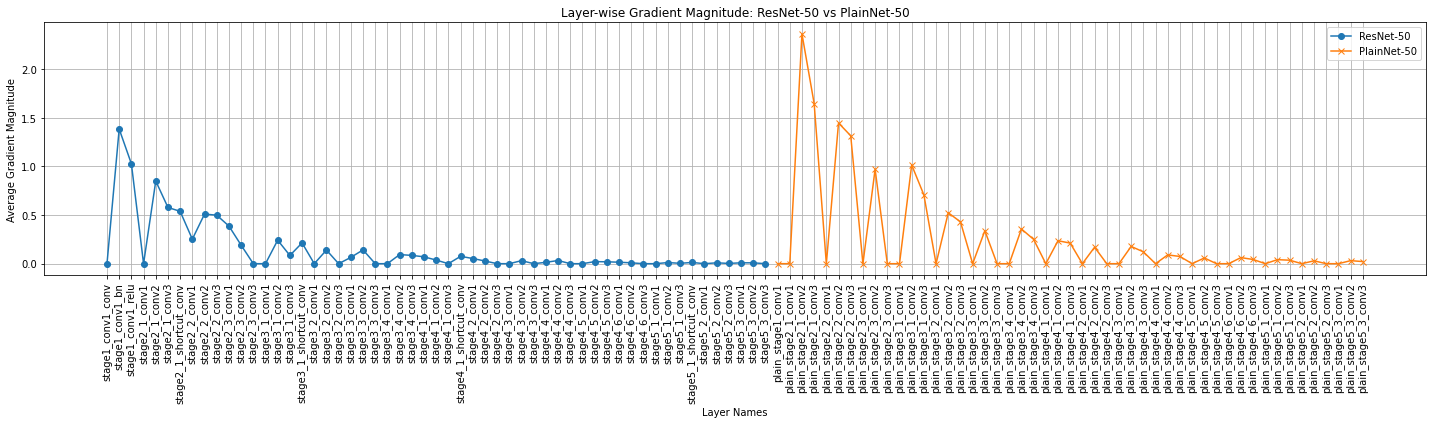

In [144]:
# 그래프 그리기
plt.figure(figsize=(20, 6))
plt.plot(resnet_layers, resnet_grad_values, label='ResNet-50', marker='o')
plt.plot(plainnet_layers, plainnet_grad_values, label='PlainNet-50', marker='x')
plt.xticks(rotation=90)  # x축 레이블 기울이기
plt.xlabel('Layer Names')
plt.ylabel('Average Gradient Magnitude')
plt.title('Layer-wise Gradient Magnitude: ResNet-50 vs PlainNet-50')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
18번 / 22번

### 추가 노드2 VGG 공부 _ 분석은 이후에

VGG 블록 공부  
최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 블록(block) 이라고 부릅니다. 레이어(layer) 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위입니다. 우리는 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 합니다.

VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어집니다.  
CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있습니다.  
그리고 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있습니다.  
블록에 따라서 CNN 레이어의 개수 또한 달라집니다. 블록의 마지막에는 항상 Max Pooling 레이어가 붙습니다.  
따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 합니다.

이제 위에서 만든 VGG 블록을 추가하는 함수를 이용해서 input_layer 에 추가를 해 봅시다. 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 가로 세로 크기를 가지고 채널로 3을 가지므로 (32,32,3) 이 됩니다. 이 입력 레이어를 인자로 받아 build_vgg_block() 는 블록의 레이어를 build하고 출력값을 얻을 수 있습니다. 이제 케라스의 Model 클래스에서 input과 output을 정의해 주면 간단히 블록의 모델을 확인해볼 수 있습니다.







In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

In [ ]:
# VGG 모델 자체를 생성하는 함수
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()